# Top

In [1]:
import mlp
import meta_poisoning_typical as mp

import jax
import jax.numpy as jnp
from flax import struct
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree
from optax import (
    softmax_cross_entropy as dense_xent,
    softmax_cross_entropy_with_integer_labels as sparse_xent
)
import optax

import numpy as np
from scipy import stats
from sklearn.datasets import load_digits

from typing import Optional, Callable
import matplotlib.pyplot as plt
from tqdm import tqdm


from importlib import reload

/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
reload(mlp)

<module 'mlp' from '/home/adam/src/basin-volume/mlp.py'>

# Defns

## Training

In [4]:
def make_split(X, Y, splits: list[int], key: jax.random.PRNGKey) -> list[tuple[jnp.ndarray, jnp.ndarray]]:
    if splits[-1] == -1:
        splits[-1] = len(X) - sum(splits[:-1])

    indices = jax.random.permutation(key, len(X))
    for split in splits:
        yield X[indices[:split]], Y[indices[:split]]
        indices = indices[split:]

def get_digits_splits(key: jax.random.PRNGKey, splits: list[int]) -> list[tuple[jnp.ndarray, jnp.ndarray]]:
    X, Y = load_digits(return_X_y=True)
    X = X / 16.0
    return make_split(X, Y, splits, key)

In [5]:
@struct.dataclass
class SimpleConfig:
    seed: int = 0

    train_size: int = 768
    num_layers: int = 1
    
    batch_size: int = 64
    num_epochs: int = 25

    opt: str = "sgd"
    lr: float = 0.1
    weight_decay: float = 0.0

    mesa_constrain: bool = False
    norm_scale: float = 1.0

In [6]:
def get_model(cfg: SimpleConfig, x):
    seed = cfg.seed
    key = jax.random.key(seed)

    d_inner = x.shape[1]

    model = mlp.MLP(hidden_sizes=(d_inner,) * cfg.num_layers, 
                out_features=10, 
                norm_scale=cfg.norm_scale)
    
    params = mlp.Raveler({'params': model.init(key, x)['params']})

    return model, params

In [7]:

def make_apply_full(model, unraveler):
    """Make an apply function that takes the full parameter vector."""
    def apply_full(raveled, x):
        params = unraveler(raveled)
        return model.apply(params, x)
    
    return apply_full

def compute_loss(params, apply_fn, X, Y):
    logits = apply_fn(params['p'], X)
    preds = jnp.argmax(logits, axis=-1)

    loss = sparse_xent(logits, Y).mean()
    acc = jnp.mean(preds == Y)
    return loss, acc

def train_simple(
    params_raveled, unravel: Callable, digits_splits, apply_fn, cfg: SimpleConfig,
    target_norm: Optional[float] = None, return_state: bool = False,
):
    x_train, y_train = digits_splits[0]
    x_test, y_test = digits_splits[1]
    x_shape = x_train[0].shape
    x_train, y_train = jnp.array(x_train), jnp.array(y_train)

    # LR schedule
    num_steps = cfg.num_epochs * len(x_train) // cfg.batch_size

    # Define the optimizer and training state
    if cfg.opt == "adam":
        sched = optax.cosine_decay_schedule(cfg.lr, num_steps)
        tx = optax.adamw(learning_rate=sched, eps_root=1e-8, weight_decay=cfg.weight_decay)
    else:
        sched = optax.cosine_decay_schedule(cfg.lr, num_steps)
        tx = optax.sgd(learning_rate=sched, momentum=0.9)

    if target_norm is not None:
        params_raveled = params_raveled * target_norm / norm(params_raveled)
    elif cfg.mesa_constrain:
        target_norm = norm(params_raveled)

    state = TrainState.create(apply_fn=apply_fn, params=dict(p=params_raveled), tx=tx)

    # Forward and backward pass
    loss_and_grad = jax.value_and_grad(compute_loss, has_aux=True)

    # RNG key for each epoch
    keys = jax.vmap(jax.random.key)(jnp.arange(cfg.num_epochs))

    def train_step(state: TrainState, batch):
        loss, grads = loss_and_grad(state.params, state.apply_fn, *batch)
        state = state.apply_gradients(grads=grads)
        if target_norm is not None:
            state.params['p'] *= target_norm / norm(state.params['p'])
        return state, loss

    def epoch_step(state: TrainState, key) -> tuple[TrainState, tuple[jnp.ndarray, jnp.ndarray]]:
        # Re-shuffle the data at the start of each epoch
        indices = jax.random.permutation(key, len(x_train))
        x_train_, y_train_ = x_train[indices], y_train[indices]

        # Create the batches
        x_train_batches = jnp.reshape(x_train_, (-1, cfg.batch_size, *x_shape))
        y_train_batches = jnp.reshape(y_train_, (-1, cfg.batch_size))
        
        state, (losses, accs) = jax.lax.scan(train_step, state, (x_train_batches, y_train_batches))
        return state, (losses.mean(), accs.mean())

    state, (train_loss, _) = jax.lax.scan(epoch_step, state, keys)

    # Test loss
    logits = state.apply_fn(state.params['p'], x_test)
    test_loss = sparse_xent(logits, y_test).mean()

    if return_state:
        return test_loss, train_loss[-1], state
    return test_loss, train_loss[-1]


## Radius-finding

In [8]:
def find_radius(center, vec, cutoff, fn, rtol=1e-1, 
                high=None, low=0, init_mult=1, iters=10, jump=2.0):
    center_loss = fn(center, 0 * vec)
    vec_loss = fn(center, init_mult * vec)

    delta = vec_loss - center_loss

    if iters == 0 or jnp.abs(delta - cutoff) < cutoff * rtol:
        return init_mult, delta
    if delta < cutoff:  # too low  
        low = init_mult
        if high is None:
            new_init_mult = init_mult * jump
        else:
            new_init_mult = (high + low) / 2
    else:  # too high
        high = init_mult
        new_init_mult = (high + low) / 2
    
    return find_radius(center, vec, cutoff, fn=fn, rtol=rtol, high=high, low=low, init_mult=new_init_mult, iters=iters - 1)

In [9]:
def find_radius_vectorized(center, vecs, cutoff, fn, 
                           rtol=1e-1,  
                           init_mult=1, iters=10, jump=2.0):
    mults = init_mult * jnp.ones(vecs.shape[0])
    highs = jnp.inf * jnp.ones(vecs.shape[0])
    lows = jnp.zeros(vecs.shape[0])

    center_losses = jax.vmap(fn, in_axes=(None, 0))(center, 0 * vecs)
    vec_losses = jax.vmap(fn, in_axes=(None, 0))(center, jnp.einsum('b,bn->bn', mults, vecs))
    deltas = vec_losses - center_losses

    while iters > 0 and jnp.any(jnp.abs(deltas - cutoff) > cutoff * rtol):
        center_losses = jax.vmap(fn, in_axes=(None, 0))(center, 0 * vecs)
        vec_losses = jax.vmap(fn, in_axes=(None, 0))(center, jnp.einsum('b,bn->bn', mults, vecs))
        deltas = vec_losses - center_losses

        low = deltas < cutoff
        high = deltas > cutoff

        lows = jnp.where(low, mults, lows)
        highs = jnp.where(high, mults, highs)

        mults = jnp.where(highs == jnp.inf, mults * jump, (highs + lows) / 2)

        iters -= 1

    return mults, deltas

In [10]:
def find_radius_newton(center, vec, cutoff, fn, rtol=1e-1, 
                       init_mult=1., iters=10):
    def mult_fn(mult):
        return fn(center, mult * vec)
    
    center_loss = mult_fn(0)
    vec_loss, grad = jax.value_and_grad(mult_fn)(init_mult)

    delta = vec_loss - center_loss
    error = delta - cutoff

    if iters == 0 or jnp.abs(error) < cutoff * rtol:
        return init_mult, delta
    
    new_init_mult = init_mult - error / grad
    
    return find_radius_newton(center, vec, cutoff, fn=fn, rtol=rtol, init_mult=new_init_mult, iters=iters - 1)

## Geometry

In [11]:

def log_hyperball_volume(dim):
    return (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2 + 1)

def log_hypersphere_area(dim):
    return jnp.log(2) + (dim / 2) * jnp.log(jnp.pi) - jax.scipy.special.gammaln(dim / 2)

def log_small_hyperspherical_cap(dim, t, angle=False):
    x = jnp.sin(t)
    logr = jnp.log(t) if angle else jnp.log(x)
    return (dim - 1) * logr + log_hyperball_volume(dim - 1) - log_hypersphere_area(dim)

def log_small_hyperspherical_cap_h(dim, h, angle=False):
    x = jnp.sqrt(2 * h - h**2)
    t = jnp.arctan(x / (1 - h))
    logr = jnp.log(t) if angle else jnp.log(x)
    return (dim - 1) * logr + log_hyperball_volume(dim - 1) - log_hypersphere_area(dim)

## Utility

In [ ]:
norm = jnp.linalg.norm

In [12]:
def unit(v):
    return v / jnp.linalg.norm(v)

In [296]:
def orthogonal_complement(r):
    r = unit(r)
    eye = jnp.eye(r.shape[0])
    u = eye[0] - r
    u = unit(u)
    hou = eye - 2 * jnp.outer(u, u)
    return hou[:, 1:]

In [112]:
def logrectdet(M):
    return jnp.sum(jnp.log(jnp.linalg.svdvals(M)))

def rectdet(M):
    return jnp.exp(jnp.sum(jnp.log(jnp.linalg.svdvals(M))))

In [13]:
def logspace(start, end, num):
    return 10**jnp.linspace(jnp.log10(start), jnp.log10(end), num)

In [209]:
linspace = jnp.linspace

In [14]:
def logspace_indices(length, num):
    # logarithically spaced indices from each end towards the middle
    num_beginning = num // 2 + 1
    num_end = num - num_beginning
    beginning = logspace(1, length // 2 + 1, num_beginning)
    beginning -= 1
    end = length - logspace(1, (length - length // 2) + 1, num_end + 1)
    end = end[-2::-1]
    return jnp.concatenate([beginning, end]).astype(int)    

In [15]:


def normal_probability_plot(data, figsize=(10, 6), title="Normal Probability Plot"):
    """
    Create a normal probability plot for the given data.
    
    Parameters:
    - data: JAX array or list of data points
    - figsize: tuple, size of the figure (width, height)
    - title: str, title of the plot
    
    Returns:
    - fig, ax: matplotlib figure and axis objects
    """
    # Convert to JAX array if it's not already
    if not isinstance(data, jnp.ndarray):
        data = jnp.array(data)
    
    # Normalize the data
    normalized_data = (data - jnp.mean(data)) / jnp.std(data)
    
    # Sort the normalized data
    sorted_data = jnp.sort(normalized_data)
    
    # Calculate theoretical quantiles
    n = len(sorted_data)
    theoretical_quantiles = stats.norm.ppf((jnp.arange(1, n+1) - 0.5) / n)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot the points
    ax.scatter(theoretical_quantiles, sorted_data, alpha=0.5)
    
    # Plot the line y=x
    ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")
    
    # Set labels and title
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Sample Quantiles (Normalized)")
    ax.set_title(title)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    return fig, ax

# Example usage:
# fig, ax = normal_probability_plot(estimates_100k)
# plt.show()

In [16]:
def summarize(obj, size_limit=10, str_limit=100):
    if type(obj) in [int, float, bool]:
        return obj
    if isinstance(obj, str) and len(obj) <= str_limit:
        return obj
    out = {}
    out['type'] = type(obj)
    out['size'] = get_size(obj)
    info = get_info(obj)
    if info is not None:
        out['info'] = info
    if out['size'] <= size_limit:
        out['contents'] = get_contents(obj, size_limit)
    return out

def get_info(obj):
    if isinstance(obj, jax.Array) or isinstance(obj, np.ndarray):
        return {'shape': obj.shape, 'dtype': obj.dtype}
    else:
        return None

def get_contents(obj, size_limit):
    if isinstance(obj, jax.Array) or isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return [{'key': summarize(k, size_limit), 'value': summarize(v, size_limit)} for k, v in obj.items()]
    elif any(isinstance(obj, t) for t in [list, tuple, set]):
        return [summarize(v, size_limit) for v in obj]
    elif isinstance(obj, str):
        return obj
    else:
        raise ValueError(f"Unsupported type: {type(obj)}")

def get_size(obj):
    if isinstance(obj, jax.Array) or isinstance(obj, np.ndarray):
        return obj.size
    elif any(isinstance(obj, t) for t in [dict, list, tuple, set, str]):
        return len(obj)
    else:
        raise ValueError(f"Unsupported type: {type(obj)}")

In [17]:
def flatten_dict(d):
    new_d = {}
    for k, v in d.items():
        if isinstance(v, dict):
            for k2, v2 in flatten_dict(v).items():
                new_d[(k,) + k2] = v2
        else:
            new_d[(k,)] = v
    return new_d

# Training etc

In [18]:
cfg = SimpleConfig(train_size=1024, 
                   opt="adam", 
                   lr=.05,
                   mesa_constrain=True,
                   norm_scale=2.0,
                   )

In [19]:
digits_splits = list(get_digits_splits(jax.random.key(cfg.seed), [cfg.train_size, -1]))
X_train, Y_train = digits_splits[0]
X_test, Y_test = digits_splits[1]
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

2024-10-24 18:30:24.047901: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


((1024, 64), (1024,), (773, 64), (773,))

In [20]:
model, init_params = get_model(cfg, X_train)

apply_fn = make_apply_full(model, init_params.unravel)

In [21]:
param_dim = init_params.raveled.shape[0]

In [22]:
def loss_fn(params_raveled):
    loss, acc = compute_loss({'p': params_raveled}, apply_fn, X_train, Y_train)
    return loss

In [23]:
def quick_train(cfg=cfg, init_params=init_params, digits_splits=digits_splits, apply_fn=apply_fn):
    return train_simple(init_params.raveled, init_params.unravel, digits_splits, apply_fn, cfg, return_state=True)

In [24]:
test_loss, train_loss, state = quick_train()

In [25]:
final_params = mlp.Raveler(state.params['p'], init_params.unravel)

## H

In [273]:
H = jax.hessian(loss_fn)(final_params.raveled)

In [27]:
evals, evecs = jnp.linalg.eigh(H)
# evals: [n]
# evecs: [n, n]
# top eigenvector is evecs[:, -1]

In [187]:
eye = jnp.eye(param_dim)

## Vol estimates

In [29]:
def logvol_estimate(params, fn, key, newton):
    center = params.raveled
    vec = jax.random.normal(key, center.shape)
    vec = unit(vec)
    if newton:
        mult, delta = find_radius_newton(center, vec, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)
    else:
        mult, delta = find_radius(center, vec, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)
    return center.shape[0] * jnp.log(mult), delta

In [30]:
def aggregate(estimates):
    return jax.scipy.special.logsumexp(jnp.array(estimates), b=1/len(estimates))

In [31]:
def logvol_estimate_preconditioned(params, fn, key, preconditioner, newton):
    center = params.raveled
    vec = jax.random.normal(key, center.shape)
    vec = unit(vec)
    vec = preconditioner @ vec
    if newton:
        mult, delta = find_radius_newton(center, vec, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)
    else:
        mult, delta = find_radius(center, vec, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)
    return center.shape[0] * jnp.log(mult), delta

In [32]:
def get_estimates_preconditioned(n, preconditioner=eye, fn=None, params=final_params, show_progress=True, newton=False):
    if fn is None:
        fn = lambda a, b: loss_fn(a + b)

    keys = jax.random.split(jax.random.key(cfg.seed), n)

    estimates = []
    diffs = []
    if show_progress:
        keys = tqdm(keys)
    else:
        keys = keys

    for key in keys:
        est, diff = logvol_estimate_preconditioned(params, fn, key, preconditioner, newton=newton)
        estimates.append(est)
        diffs.append(diff)
    estimates = jnp.array(estimates)
    diffs = jnp.array(diffs)

    return estimates, diffs

In [272]:
def get_estimates_vectorized(n, 
                             preconditioner=eye, 
                             fn=None, 
                             params=final_params):
    if fn is None:
        fn = lambda a, b: loss_fn(a + b)

    center = params.raveled
    vecs = jax.random.normal(jax.random.key(cfg.seed), (n, center.shape[0]))
    vecs = jax.vmap(unit)(vecs)
    vecs = vecs @ preconditioner.T

    props = norm(vecs, axis=1)

    mults, deltas = find_radius_vectorized(center, vecs, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)

    estimates = center.shape[0] * jnp.log(mults)

    return estimates, props, mults, deltas

### Sphere

In [34]:
def loss_fn_sphere(rad, vec):
    # assert jnp.abs(rad @ vec) < 1e-6, f"rad @ vec = {rad @ vec}"
    
    theta = norm(vec) / norm(rad)
    
    # tang = vec / theta  # tangent vector with norm equal to rad
    # x = rad * jnp.cos(theta) + tang * jnp.sin(theta)

    # equivalent to above but more numerically stable
    # note that jnp.sinc(x / jnp.pi) = jnp.sin(x) / x
    x = rad * jnp.cos(theta) + vec * jnp.sinc(theta / jnp.pi)

    # assert jnp.abs(norm(x) - norm(rad)) < 1e-5, f"norm(x) = {norm(x)}, norm(rad) = {norm(rad)}"

    return loss_fn(x)

In [301]:
def loss_fn_proj(x, rad):
    vec = orthogonal_complement(rad) @ x
    pt = rad + vec
    pt = unit(pt) * norm(rad)
    return loss_fn(pt)

In [302]:
H_sphere = jax.hessian(loss_fn_proj)(jnp.zeros(param_dim - 1), final_params.raveled)

In [108]:
def logvol_estimate_sphere(params, fn, key, preconditioner):
    center = params.raveled
    rhat = unit(center)
    if preconditioner is None:
        vec = jax.random.normal(key, center.shape)
    else:
        vec = jax.random.normal(key, preconditioner.shape[1])
        vec = unit(vec)
        vec = preconditioner @ vec
    # project vec onto tangent space exactly
    vec = vec - rhat * (rhat @ vec)
    if preconditioner is None:
        vec = unit(vec)
    prop = norm(vec)
    mult, delta = find_radius(center, vec, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)
    theta = mult * prop / norm(center)
    D = center.shape[0]
    logvol = log_small_hyperspherical_cap(D, theta) - (D - 1) * jnp.log(prop)
    return logvol, prop, mult, delta

In [310]:
def check_preconditioner(preconditioner, rhat):
    logdet = logrectdet(preconditioner)
    assert jnp.abs(logdet) < 0.1, f"logrectdet(preconditioner) = {logdet}"
    maxradial = jnp.max(jnp.abs(rhat @ preconditioner))
    assert maxradial < 1e-3, f"max(abs(rhat @ preconditioner)) = {maxradial}"

In [129]:
def get_estimates_sphere(n, preconditioner=None, fn=None, params=final_params, show_progress=True):
    if fn is None:
        fn = loss_fn_sphere

    if preconditioner is not None:
        check_preconditioner(preconditioner, unit(params.raveled))

    keys = jax.random.split(jax.random.key(cfg.seed), n)

    outs = []
    if show_progress:
        keys = tqdm(keys)
    else:
        keys = keys

    for key in keys:
        out = logvol_estimate_sphere(params, fn, key, preconditioner)
        outs.append(out)
    outs = jnp.array(outs)
    estimates, props, mults, deltas = outs.T

    return estimates, props, mults, deltas

In [130]:
def get_estimates_sphere_vectorized(n, preconditioner=None, fn=None, params=final_params, show_progress=True):
    if fn is None:
        fn = loss_fn_sphere

    center = params.raveled
    rhat = unit(center)

    if preconditioner is not None:
        check_preconditioner(preconditioner, rhat)

    if preconditioner is None:
        vecs = jax.random.normal(jax.random.key(cfg.seed), (n, center.shape[0]))
    else:
        vecs = jax.random.normal(jax.random.key(cfg.seed), (n, preconditioner.shape[1]))
        vecs = jax.vmap(unit)(vecs)
        vecs = vecs @ preconditioner.T
    # project vecs onto tangent space
    vecs = vecs - jnp.outer(vecs @ rhat, rhat)
    if preconditioner is None:
        vecs = jax.vmap(unit)(vecs)

    props = norm(vecs, axis=1)

    mults, deltas = find_radius_vectorized(center, vecs, cutoff=1e-3, fn=fn, iters=100, rtol=1e-2)
    thetas = mults * props / norm(center)
    D = center.shape[0]
    logvols = log_small_hyperspherical_cap(D, thetas) - (D - 1) * jnp.log(props)

    return logvols, props, mults, deltas

# Experiments

## Hessian sphere projection

In [306]:
def sphere_hessian_preconditioner(params, H, eps=1e-3, exponent=0.5, tangent=False):
    M = orthogonal_complement(params.raveled)

    if tangent:
        Htan = H
    else:
        Htan = M.T @ H @ M
    evalsHtan, evecsHtan = jnp.linalg.eigh(Htan)

    p = 1 / (jnp.abs(evalsHtan)**exponent + eps)
    logp = jnp.log(p)
    logp_norm = logp - jnp.mean(logp)
    p = jnp.exp(logp_norm)
    Ptan = jnp.einsum('ij,j->ij', evecsHtan, p)
    P = M @ Ptan

    return P

def flat_hessian_preconditioner(params, H, eps=1e-3, exponent=0.5):
    evals, evecs = jnp.linalg.eigh(H)
    
    p = 1 / (jnp.abs(evals)**exponent + eps)
    logp = jnp.log(p)
    logp_norm = logp - jnp.mean(logp)
    p = jnp.exp(logp_norm)
    P = jnp.einsum('ij,j->ij', evecs, p)
    return P

In [185]:
v = final_params.raveled

In [188]:
r = unit(v)

# evalsP, evecsP = jnp.linalg.eigh(eye - jnp.outer(r, r))
# M = evecsP[:, 1:]

u = eye[0] - r
u = unit(u)
hou = eye - 2 * jnp.outer(u, u)
M = hou[:, 1:]

Htan = M.T @ H @ M
evalsHtan, evecsHtan = jnp.linalg.eigh(Htan)

In [189]:
p = 1 / (jnp.sqrt(jnp.abs(evalsHtan)) + 1e-3)
logp = jnp.log(p)
logp_norm = logp - jnp.mean(logp)
p = jnp.exp(logp_norm)
Ptan = jnp.einsum('ij,j->ij', evecsHtan, p)
P = M @ Ptan

### Failures

In [ ]:
loss_fn_2 = lambda a, b: loss_fn(a + b)

H2 = jax.hessian(loss_fn_2, argnums=1)(final_params.raveled, 0 * final_params.raveled)

In [ ]:
H_sphere = jax.hessian(loss_fn_sphere, argnums=1)(final_params.raveled, 0 * final_params.raveled)

In [ ]:
def hess_fn_sphere(x, rad):
    vec = orthogonal_complement(rad) @ x
    return loss_fn_sphere(rad, vec)

In [ ]:
H_sphere = jax.hessian(hess_fn_sphere)(jnp.zeros(param_dim - 1), final_params.raveled)

In [ ]:
loss_fn_sphere(final_params.raveled, 0 * final_params.raveled)

Array(0.0223845, dtype=float32)

### Plots etc

In [ ]:
jnp.max(jnp.abs(unit(v) @ P))

Array(2.864981e-05, dtype=float32)

In [157]:
u = eye[0] - r
u = unit(u)
hou = eye - 2 * jnp.outer(u, u)

norm((hou @ r)[1:])

Array(4.6714308e-07, dtype=float32)

In [151]:

evalsP, evecsP = jnp.linalg.eigh(eye - jnp.outer(r, r))

In [152]:
norm(r @ evecsP[:, 1:])

Array(7.1745984e-07, dtype=float32)

In [138]:
jnp.sort(r @ evecsP)

Array([-1.8998981e-07, -8.0093741e-08, -6.8452209e-08, ...,
        1.5879050e-07,  1.8300489e-07,  1.0000001e+00], dtype=float32)

In [148]:

evalsP, evecsP = jnp.linalg.eigh(jnp.outer(r, r))

In [150]:
norm(r @ evecsP[:, :-1])

Array(6.9360607e-07, dtype=float32)

In [135]:
jnp.sort(r @ evecsP)

Array([-9.9999982e-01, -1.0430813e-07, -9.3132257e-08, ...,
        8.7544322e-08,  9.1269612e-08,  9.6857548e-08], dtype=float32)

In [93]:
def rectdet(M):
    return jnp.exp(jnp.sum(jnp.log(jnp.linalg.svdvals(M))))

In [190]:
rectdet(M), rectdet(Ptan), rectdet(M @ Ptan)

(Array(0.99956155, dtype=float32),
 Array(1.0008568, dtype=float32),
 Array(1.0663193, dtype=float32))

In [191]:
jnp.linalg.det(Ptan)

Array(1.0007193, dtype=float32)

In [103]:
A = jax.random.uniform(jax.random.key(cfg.seed), (20, 10))
B = jax.random.uniform(jax.random.key(cfg.seed), (10, 10))
rectdet(A) * rectdet(B), rectdet(A @ B)

(Array(0.17730005, dtype=float32), Array(0.17730136, dtype=float32))

## MC on sphere

### Fitting H precond

In [240]:
# inverse normal cdf
stats.norm.ppf(1 - 1/3000)

np.float64(3.402932835385335)

In [251]:
epses = logspace(.01, .02, 11)
exponent = 1.0
for eps in epses:
    P = sphere_hessian_preconditioner(final_params, H, eps, exponent)
    results = get_estimates_sphere_vectorized(3_000, P)
    print(f'{eps:.4f}, \
    {results[0].max() / jnp.log(10):.4f}, \
    {(results[0].mean() + 3.4 * results[0].std()) / jnp.log(10):.4f}, \
    {results[0].std() / jnp.log(10):.4f}')

0.0100,     -4116.7969,     -4126.2534,     180.1916
0.0107,     -4110.0557,     -4123.8916,     182.5269
0.0115,     -4106.6885,     -4121.9937,     184.8151
0.0123,     -4106.6777,     -4120.8579,     186.9261
0.0132,     -4104.1543,     -4119.8657,     189.0205
0.0141,     -4103.3071,     -4119.6074,     190.9851
0.0152,     -4099.9521,     -4119.9165,     192.8216
0.0162,     -4099.9438,     -4120.6357,     194.5775
0.0174,     -4103.2817,     -4121.5049,     196.3225
0.0187,     -4103.2734,     -4123.2217,     197.8559
0.0200,     -4103.2666,     -4125.1582,     199.3658


In [252]:
eps = .014
exponents = linspace(.95, 1.15, 11)
for exponent in exponents:
    P = sphere_hessian_preconditioner(final_params, H, eps, exponent)
    results = get_estimates_sphere_vectorized(3_000, P)
    print(f'{exponent:.4f}, \
    {results[0].max() / jnp.log(10):.4f}, \
    {(results[0].mean() + 3.4 * results[0].std()) / jnp.log(10):.4f}, \
    {results[0].std() / jnp.log(10):.4f}')

0.9500,     -4114.2495,     -4126.8730,     182.3010
0.9700,     -4106.6768,     -4123.1445,     185.8654
0.9900,     -4103.3135,     -4120.6733,     189.1158
1.0100,     -4100.7944,     -4118.8672,     192.2094
1.0300,     -4096.6089,     -4117.9038,     195.0373
1.0500,     -4096.5996,     -4117.6406,     197.6691
1.0700,     -4096.5923,     -4117.9805,     200.1012
1.0900,     -4096.5850,     -4118.9307,     202.3562
1.1100,     -4099.9189,     -4120.6885,     204.3472
1.1300,     -4100.7500,     -4122.8301,     206.1775
1.1500,     -4103.2544,     -4125.4775,     207.8767


#### Sphere

In [313]:
eps = .015
exponents = linspace(.5, 1.5, 11)
for exponent in exponents:
    P = sphere_hessian_preconditioner(final_params, H_sphere, eps, exponent, tangent=True)
    results = get_estimates_sphere_vectorized(3_000, P)
    print(f'{exponent:.4f}, \
    {results[0].max() / jnp.log(10):.4f}, \
    {(results[0].mean() + 3.4 * results[0].std()) / jnp.log(10):.4f}, \
    {results[0].std() / jnp.log(10):.4f}')

0.5000,     -4161.4375,     -4161.0557,     133.2089
0.6000,     -4154.4512,     -4159.2021,     136.4437
0.7000,     -4130.4565,     -4143.4756,     147.6625
0.8000,     -4096.7183,     -4122.6577,     163.6327
0.9000,     -4070.1230,     -4106.8960,     180.4803
1.0000,     -4053.6682,     -4102.5596,     195.0197
1.1000,     -4056.9089,     -4110.5474,     205.8674
1.2000,     -4073.3215,     -4127.4194,     213.2278
1.3000,     -4089.8748,     -4150.0166,     217.7166
1.4000,     -4120.0278,     -4174.9722,     220.1244
1.5000,     -4147.2119,     -4199.5830,     221.3484


In [314]:
epses = linspace(.01, .02, 11)
exponent = 1.0
for eps in epses:
    P = sphere_hessian_preconditioner(final_params, H_sphere, eps, exponent, tangent=True)
    results = get_estimates_sphere_vectorized(3_000, P)
    print(f'{eps:.4f}, \
    {results[0].max() / jnp.log(10):.4f}, \
    {(results[0].mean() + 3.4 * results[0].std()) / jnp.log(10):.4f}, \
    {results[0].std() / jnp.log(10):.4f}')

0.0100,     -4062.7305,     -4102.3760,     183.4125
0.0110,     -4060.2566,     -4100.9604,     186.4613
0.0120,     -4060.2439,     -4100.6948,     188.9939
0.0130,     -4056.9573,     -4100.8467,     191.2621
0.0140,     -4056.9475,     -4101.3262,     193.3080
0.0150,     -4053.6682,     -4102.5483,     195.0190
0.0160,     -4056.9319,     -4103.8604,     196.5967
0.0170,     -4056.1079,     -4105.2236,     198.0624
0.0180,     -4056.9199,     -4106.8237,     199.3713
0.0190,     -4056.9150,     -4108.6626,     200.5351
0.0200,     -4060.1858,     -4110.7134,     201.5491


### Plots etc

In [54]:
results = get_estimates_sphere(300)

100%|██████████| 300/300 [00:23<00:00, 12.66it/s]


In [55]:
estimates, props, mults, deltas = results

In [48]:
deltas

Array([0.00108415, 0.00106552], dtype=float32)

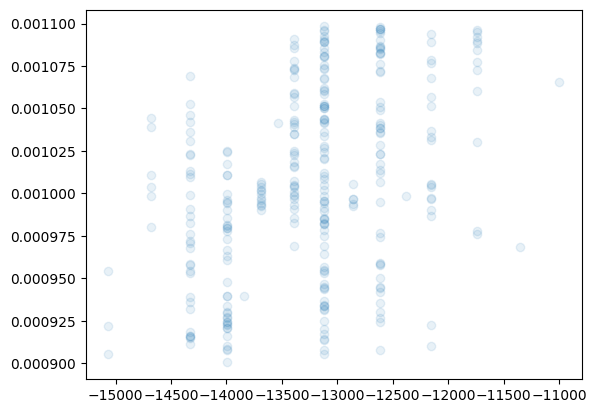

In [57]:
plt.scatter(estimates, deltas, alpha=0.1)
plt.show()

In [38]:
results_v = get_estimates_sphere_vectorized(300)

In [39]:
results_v = get_estimates_sphere_vectorized(3000)

In [164]:
results_v = get_estimates_sphere_vectorized(30_000)

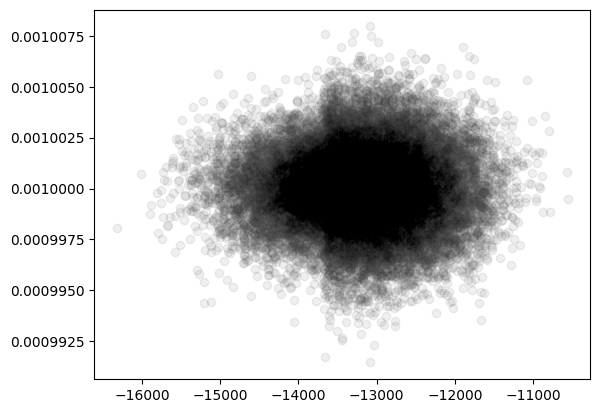

In [168]:
estimates, props, mults, deltas = results_v
plt.scatter(estimates, deltas, alpha=0.1, color='grey')
plt.scatter(estimates, deltas, alpha=0.01, color='k')
plt.show()

In [180]:
results_m = get_estimates_sphere_vectorized(30_000, M)

In [253]:
P = sphere_hessian_preconditioner(final_params, H, 1e-3, 0.5)
results_p = get_estimates_sphere_vectorized(30_000, P)

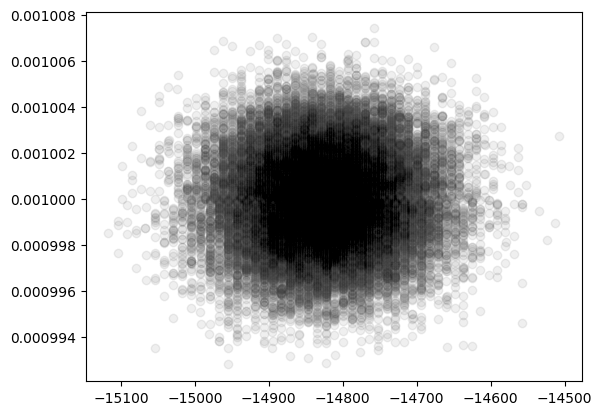

In [254]:
estimates, props, mults, deltas = results_p
plt.scatter(estimates, deltas, alpha=0.1, color='grey')
plt.scatter(estimates, deltas, alpha=0.01, color='k')
plt.show()

In [255]:
P = sphere_hessian_preconditioner(final_params, H, .015, 1.0)
results_p_opt = get_estimates_sphere_vectorized(30_000, P)

In [315]:
P = sphere_hessian_preconditioner(final_params, H_sphere, .015, 1.0, tangent=True)
results_tangent = get_estimates_sphere_vectorized(30_000, P)

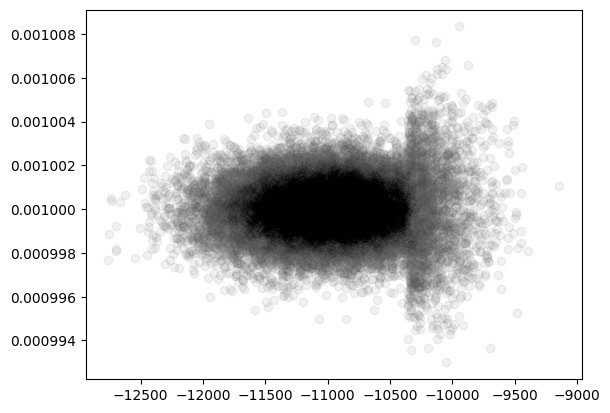

In [263]:
estimates, props, mults, deltas = results_p_opt
plt.scatter(estimates, deltas, alpha=0.1, color='grey')
plt.scatter(estimates, deltas, alpha=0.005, color='k')
plt.show()

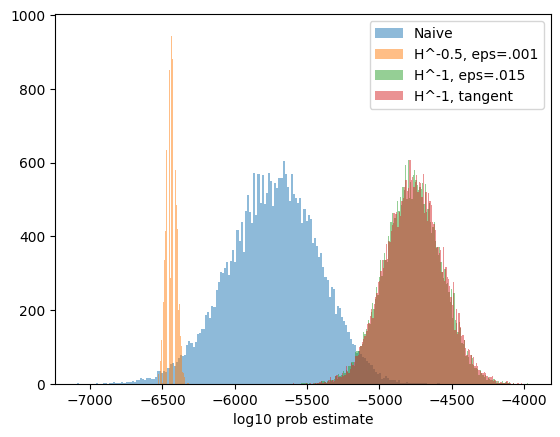

In [316]:
nbins = int(jnp.sqrt(results_v[0].shape[0]))
plt.hist(results_v[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Naive")
plt.hist(results_p[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5, eps=.001")
plt.hist(results_p_opt[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-1, eps=.015")
plt.hist(results_tangent[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-1, tangent")
#plt.hist(results_m[0] / jnp.log(10), bins=nbins, alpha=0.5, label="M")
plt.xlabel("log10 prob estimate")
plt.legend()
plt.show()

In [269]:
print(aggregate(results_p_opt[0]) / jnp.log(10))
print(jnp.sort(results_p_opt[0])[-2] / jnp.log(10))

-3975.6582
-4079.141


In [198]:
P = flat_hessian_preconditioner(final_params.raveled, H)

results_v_flat = get_estimates_vectorized(30_000)
results_p_flat = get_estimates_vectorized(30_000, P)

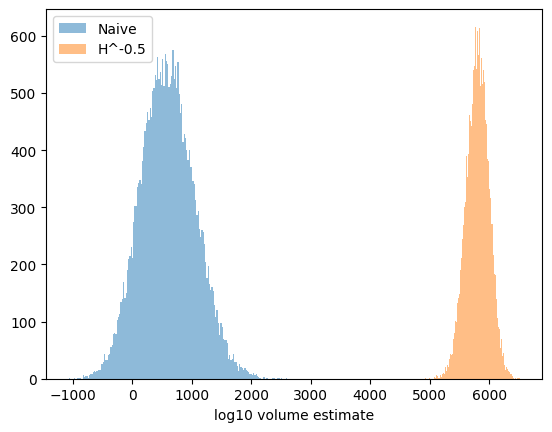

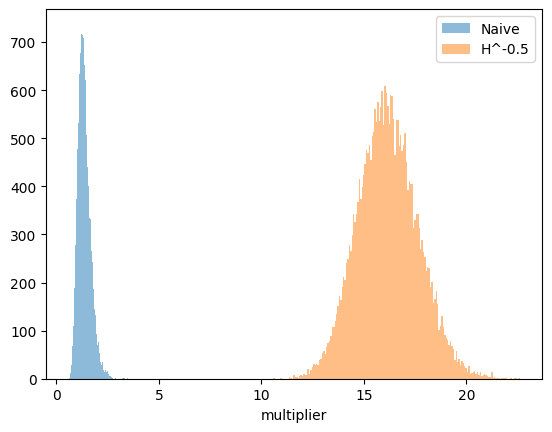

In [200]:
nbins = int(jnp.sqrt(results_v[0].shape[0]))
plt.hist(results_v_flat[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Naive")
plt.hist(results_p_flat[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.xlabel("log10 volume estimate")
plt.legend()
plt.show()
plt.hist(results_v_flat[2], bins=nbins, alpha=0.5, label="Naive")
plt.hist(results_p_flat[2], bins=nbins, alpha=0.5, label="H^-0.5")
plt.xlabel("multiplier")
plt.legend()
plt.show()

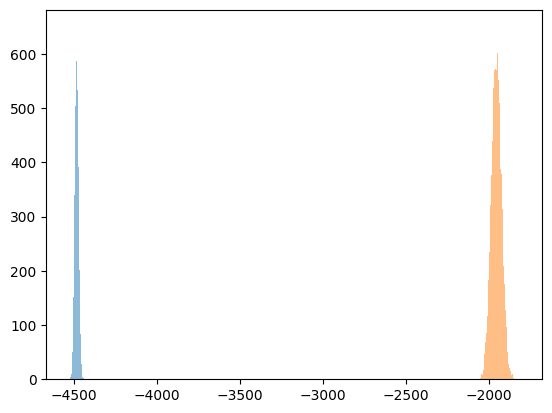

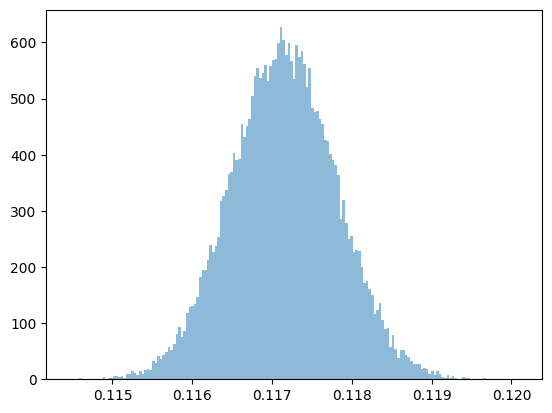

In [194]:
estimates, props, mults, deltas = results_p

center = final_params.raveled
thetas = mults * props / norm(center)
D = center.shape[0]
logvols_cap = log_small_hyperspherical_cap(D, thetas) 
logvols_prop = -(D - 1) * jnp.log(props)
logvols = logvols_cap + logvols_prop

nbins = int(jnp.sqrt(results_v[0].shape[0]))
plt.hist(logvols_cap / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.hist(logvols_prop / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.show()
plt.hist(thetas, bins=nbins, alpha=0.5, label="H^-0.5")
plt.show()

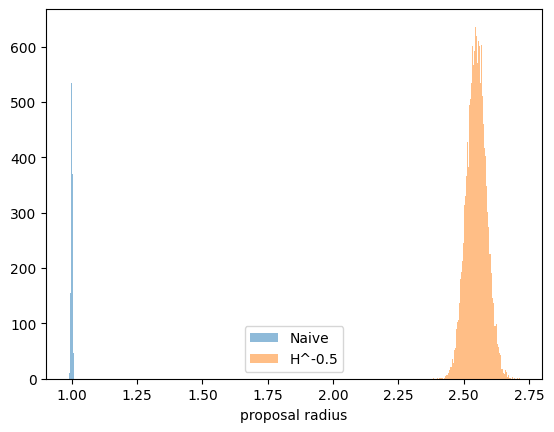

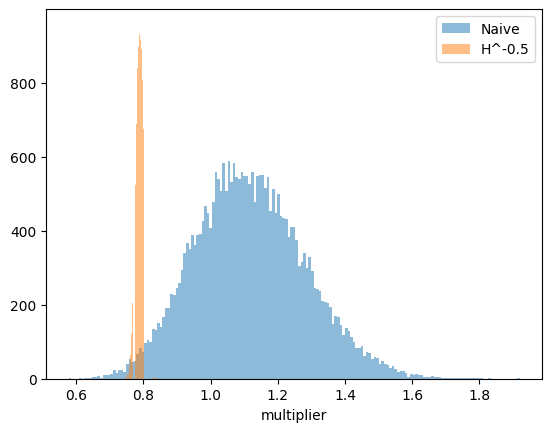

In [184]:
estimates, props, mults, deltas = results_p
nbins = int(jnp.sqrt(results_v[0].shape[0]))
plt.hist(results_v[1] + .003 * jax.random.normal(jax.random.key(cfg.seed), results_v[1].shape), bins=nbins, alpha=0.5, label="Naive")
plt.hist(results_p[1], bins=nbins, alpha=0.5, label="H^-0.5")
plt.xlabel("proposal radius")
plt.legend()
plt.show()
plt.hist(results_v[2] + .00 * jax.random.normal(jax.random.key(cfg.seed), results_v[1].shape), bins=nbins, alpha=0.5, label="Naive")
plt.hist(results_p[2], bins=nbins, alpha=0.5, label="H^-0.5")
plt.xlabel("multiplier")
plt.legend()
plt.show()

## rHr on sphere

0.003911691


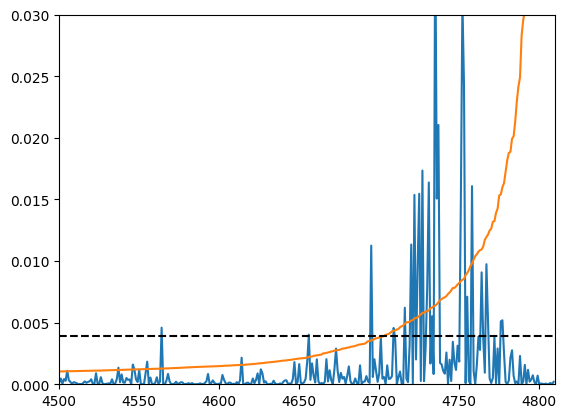

In [98]:
u = final_params.raveled / jnp.linalg.norm(final_params.raveled)
print(jnp.einsum('i,ij,j->', u, H, u))

plt.plot(jnp.einsum('i,ij->j', u, evecs)**2)
plt.plot(evals)
plt.xlim(4500, param_dim)
plt.ylim(0, .03)
plt.axhline(.0039, color='k', linestyle='--')
plt.show()

## Toy ellipsoid

In [194]:
H = jax.hessian(loss_fn)(final_params.raveled)

In [274]:
def get_H_PSD(eps):
    return evecs @ jnp.diag(jnp.abs(evals) + eps) @ evecs.T
def get_toy_loss(eps):
    H_PSD = get_H_PSD(eps)
    return lambda params_raveled: 1/2 * params_raveled.T @ H_PSD @ params_raveled
def get_estimates_toy(n, eps, preconditioner=eye):
    params = mlp.Params(jnp.zeros(param_dim), init_params.unravel)
    return get_estimates_preconditioned(n, preconditioner, fn=get_toy_loss(eps), params=params)

In [270]:
p = 1 / (jnp.sqrt(jnp.abs(evals) + 1e-6))
logp = jnp.log(p)
logp_norm = logp - jnp.mean(logp)
p = jnp.exp(logp_norm)
P = jnp.einsum('ij,j->ij', evecs, p)
P_spec = P / jnp.exp(jnp.linalg.slogdet(P).logabsdet / evecs.shape[0])

In [280]:
estimates_toy, diffs_toy = get_estimates_toy(300, 1e-6)
estimates_toy_pre, diffs_toy_pre = get_estimates_toy(300, 1e-6, P_spec)
estimates_toy_12, diffs_toy_12 = get_estimates_toy(300, 1e-12)
estimates_toy_12_pre, diffs_toy_12_pre = get_estimates_toy(300, 1e-12, P_spec)


100%|██████████| 300/300 [00:02<00:00, 106.00it/s]


In [283]:
estimates_toy_7, diffs_toy_7 = get_estimates_toy(300, 1e-7)
estimates_toy_7_pre, diffs_toy_7_pre = get_estimates_toy(300, 1e-7, P_spec)

100%|██████████| 300/300 [00:02<00:00, 126.28it/s]


In [287]:
estimates_toy_7b, diffs_toy_7b = get_estimates_toy(300, 3e-7)
estimates_toy_7b_pre, diffs_toy_7b_pre = get_estimates_toy(300, 3e-7, P_spec)

100%|██████████| 300/300 [00:02<00:00, 119.96it/s]


In [277]:
def true_logvol(eps):
    H_PSD = get_H_PSD(eps)
    return 1/2 * (param_dim * jnp.log(2e-3) - jnp.linalg.slogdet(H_PSD).logabsdet) / jnp.log(10)

In [284]:
print(true_logvol(1e-6), true_logvol(1e-12), true_logvol(1e-7))

6851.0005 12456.103 8241.604


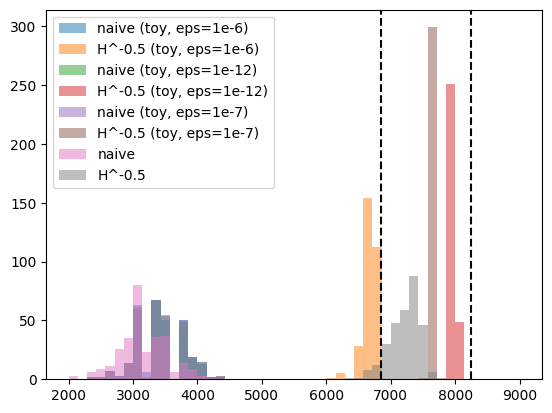

In [292]:
bins = jnp.linspace(2000, 9000, 50)
plt.hist(estimates_toy / jnp.log(10), bins=bins, alpha=0.5, label="naive (toy, eps=1e-6)")
plt.hist(estimates_toy_pre / jnp.log(10), bins=bins, alpha=0.5, label="H^-0.5 (toy, eps=1e-6)")
plt.hist(estimates_toy_12 / jnp.log(10), bins=bins, alpha=0.5, label="naive (toy, eps=1e-12)")
plt.hist(estimates_toy_12_pre / jnp.log(10), bins=bins, alpha=0.5, label="H^-0.5 (toy, eps=1e-12)")
plt.hist(estimates_toy_7 / jnp.log(10), bins=bins, alpha=0.5, label="naive (toy, eps=1e-7)")
plt.hist(estimates_toy_7_pre / jnp.log(10), bins=bins, alpha=0.5, label="H^-0.5 (toy, eps=1e-7)")
plt.hist(estimates_300 / jnp.log(10), bins=bins, alpha=0.5, label="naive")
plt.hist(estimates_300_pre / jnp.log(10), bins=bins, alpha=0.5, label="H^-0.5")
plt.axvline(true_logvol(1e-6), color='k', linestyle='--')
plt.axvline(true_logvol(1e-7), color='k', linestyle='--')
plt.legend()
plt.show()

In [ ]:
evals.min(), evals.max()

(Array(-0.00042893, dtype=float32), Array(0.08042993, dtype=float32))

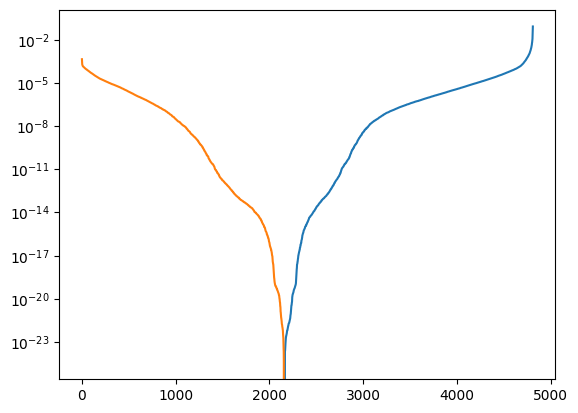

In [ ]:
plt.plot(jnp.sort(evals))
plt.plot(-jnp.sort(evals))
plt.yscale('log')
plt.show()

## Old plots

### Plots etc

(3162,) (3162,)
0.00090026023 0.0010998468


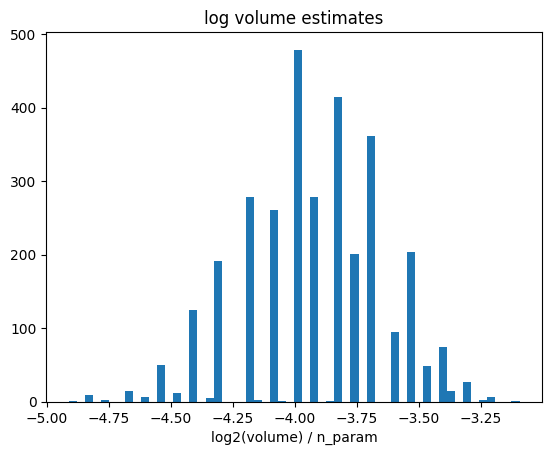

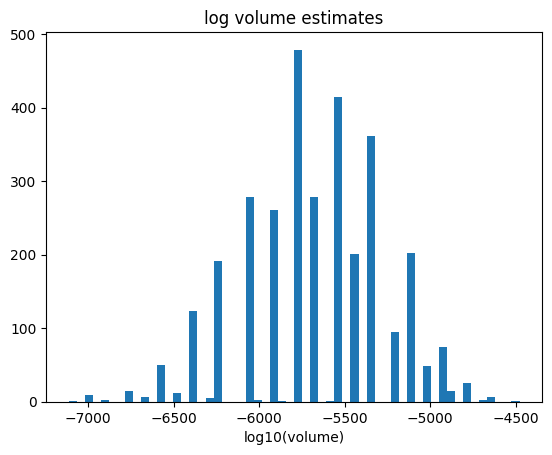

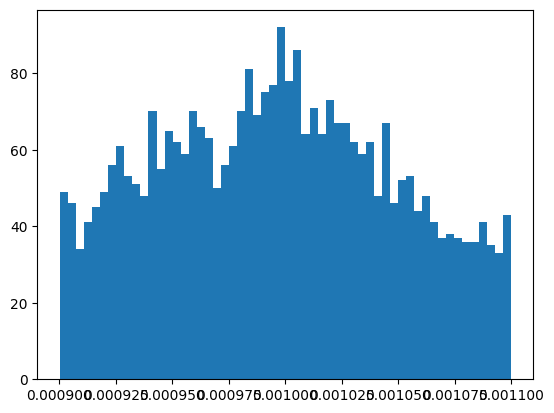

In [284]:

print(estimates.shape, diffs.shape)
print(diffs.min(), diffs.max())

n = int(10**(3.5))
param_dim = final_params.raveled.shape[0]

plt.hist(estimates / param_dim / jnp.log(2), bins=int(jnp.sqrt(n)))
plt.title('log volume estimates')
plt.xlabel('log2(volume) / n_param')
plt.show()
plt.hist(estimates / jnp.log(10), bins=int(jnp.sqrt(n)))
plt.title('log volume estimates')
plt.xlabel('log10(volume)')
plt.show()
plt.hist(diffs, bins=int(jnp.sqrt(n)))
plt.show()


In [158]:
unique = {float(x) for x in estimates}
unique = jnp.array(list(unique))
unique = jnp.sort(unique)

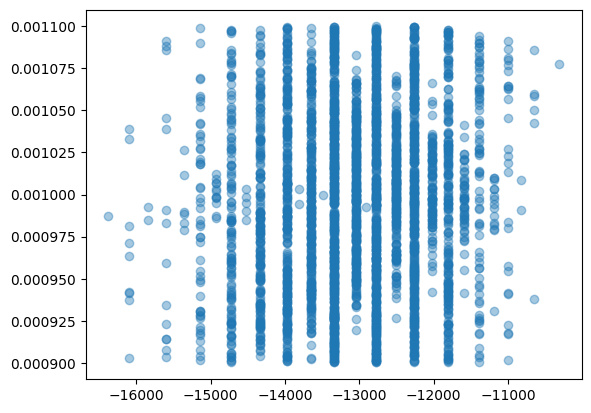

In [291]:
plt.scatter(estimates, diffs, alpha=0.4)
plt.show()

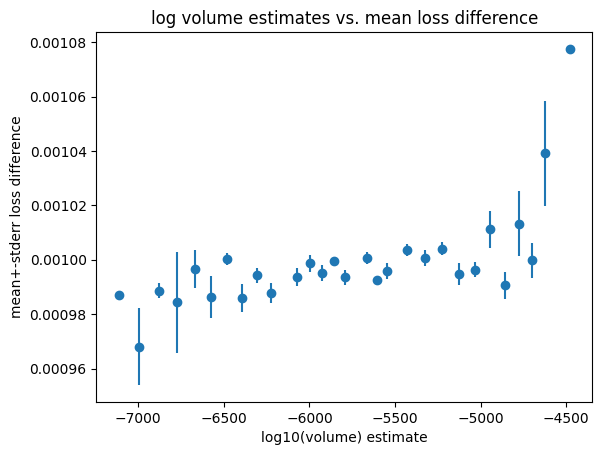

In [293]:
#plt.scatter(unique / jnp.log(10), [jnp.log10(diffs[estimates==x].mean()) for x in unique])
# error bars for std
diff_batches = [diffs[estimates==x] for x in unique]
plt.errorbar(unique / jnp.log(10), 
             [x.mean() for x in diff_batches], 
             yerr=[x.std() / jnp.sqrt(len(x)) for x in diff_batches],
             fmt='o')
plt.title('log volume estimates vs. mean loss difference')
plt.xlabel('log10(volume) estimate')
plt.ylabel('mean+-stderr loss difference')
plt.show()

In [123]:
# 3162
jnp.mean(estimates), jnp.max(estimates), jnp.min(estimates), aggregate(estimates)

(Array(-13071.879, dtype=float32),
 Array(-10312.544, dtype=float32),
 Array(-16378.585, dtype=float32),
 Array(-10320.603, dtype=float32))

In [124]:
estimates[jnp.argsort(estimates)[-10:]] / jnp.log(10), aggregate(estimates) / jnp.log(10)

(Array([-4777.613 , -4698.7744, -4698.7744, -4622.804 , -4622.804 ,
        -4622.804 , -4622.804 , -4622.804 , -4622.804 , -4478.681 ],      dtype=float32),
 Array(-4482.1807, dtype=float32))

In [140]:
(estimates_300 < -12000).sum()

Array(269, dtype=int32)

In [141]:
(estimates < -12000).sum()

Array(2787, dtype=int32)

In [135]:
# 300
jnp.mean(estimates_300), jnp.max(estimates_300), jnp.min(estimates_300), aggregate(estimates_300)

(Array(-13114.638, dtype=float32),
 Array(-10312.544, dtype=float32),
 Array(-15596.869, dtype=float32),
 Array(-10318.248, dtype=float32))

In [138]:
jnp.sort(estimates_300)[-10:] / jnp.log(10), aggregate(estimates_300) / jnp.log(10)

(Array([-4944.8184, -4944.8184, -4944.8184, -4944.8184, -4777.613 ,
        -4777.613 , -4777.613 , -4777.613 , -4622.804 , -4478.681 ],      dtype=float32),
 Array(-4481.158, dtype=float32))

In [323]:
# 300
jnp.mean(estimates_300), jnp.max(estimates_300), jnp.min(estimates_300), aggregate(estimates_300)

(Array(7284.962, dtype=float32),
 Array(10002.114, dtype=float32),
 Array(4865.801, dtype=float32),
 Array(9996.41, dtype=float32))

In [325]:
jnp.sort(estimates_300)[-10:] / jnp.log(10), aggregate(estimates_300) / jnp.log(10)

(Array([3910.1133, 3910.1133, 3910.1133, 3910.1133, 3988.9512, 4064.9219,
        4064.9219, 4064.9219, 4209.045 , 4343.8633], dtype=float32),
 Array(4341.3857, dtype=float32))

## H spectrum fitting

In [ ]:
center = final_params.raveled

idx = logspace_indices(eigvals.shape[0], 200)
rads = []
rads_neg = []
deltas = []
for i in tqdm(idx):
    vec = evecs[:, i]
    rad, delta = find_radius(center, vec, cutoff=1e-3, fn=loss_fn, iters=100, rtol=1e-2)
    rad_neg, delta_neg = find_radius(center, -vec, cutoff=1e-3, fn=loss_fn, iters=100, rtol=1e-2)
    rads.append(rad)
    rads_neg.append(rad_neg)
    deltas.append(delta)
    deltas.append(delta_neg)
rads = jnp.array(rads)
rads_neg = jnp.array(rads_neg)
deltas = jnp.array(deltas)

100%|██████████| 200/200 [00:45<00:00,  4.38it/s]


### Plots etc

In [ ]:
eigvals = jnp.linalg.eigvalsh(H)

In [ ]:
jnp.linalg.slogdet(evecs), jnp.linalg.slogdet(H), jnp.linalg.slogdet(P)

(SlogdetResult(sign=Array(-1., dtype=float32), logabsdet=Array(11.844833, dtype=float32)),
 SlogdetResult(sign=Array(0., dtype=float32), logabsdet=Array(-inf, dtype=float32)),
 SlogdetResult(sign=Array(-1., dtype=float32), logabsdet=Array(11.844204, dtype=float32)))

In [ ]:
11.844 / jnp.log(10)

Array(5.143784, dtype=float32, weak_type=True)

In [ ]:
logp_norm.min(), logp_norm.max(), logp_norm.mean(), logp_norm.std()

(Array(-4.9930286, dtype=float32),
 Array(0.658062, dtype=float32),
 Array(-1.3482298e-07, dtype=float32),
 Array(0.83437836, dtype=float32))

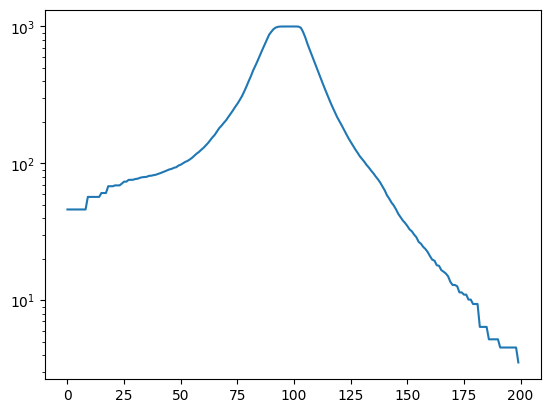

In [ ]:

plt.plot(p[idx])
plt.yscale('log')
plt.show()

In [ ]:
(eigvals == evals).all()

Array(True, dtype=bool)

(4810,)
-0.00042893144 0.080429934
2154


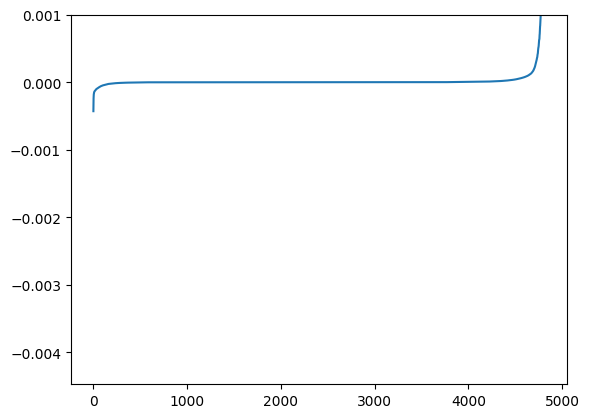

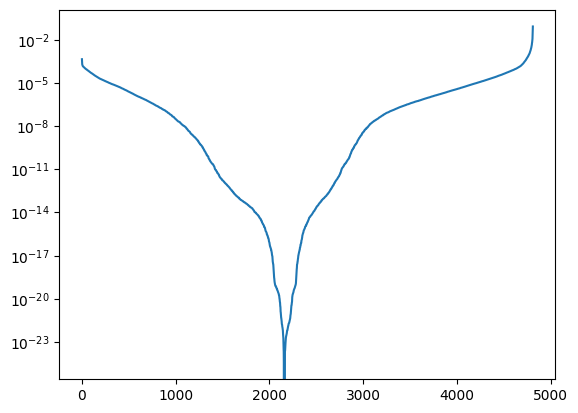

In [ ]:

print(eigvals.shape)
print(eigvals.min(), eigvals.max())
print((eigvals < 0).sum())

plt.plot(eigvals)
plt.ylim(top=.001)
plt.show()
plt.plot(jnp.abs(eigvals))
plt.yscale('log')
plt.show()


In [ ]:
jnp.min(deltas), jnp.max(deltas)

(Array(0.00090128, dtype=float32), Array(0.00109973, dtype=float32))

In [ ]:
param_dim

4810

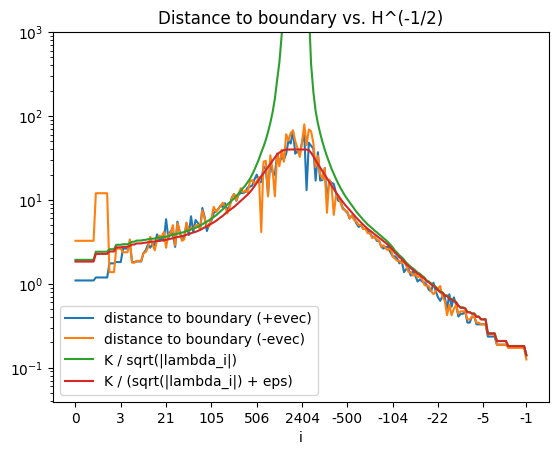

In [ ]:
eps = 1e-6

rat = rads[-1] * jnp.sqrt(jnp.abs(eigvals[-1]))

plt.plot(rads, label='distance to boundary (+evec)')
plt.plot(rads_neg, label='distance to boundary (-evec)')
plt.plot(rat/jnp.sqrt(jnp.abs(eigvals[idx])), label = 'K / sqrt(|lambda_i|)')
plt.plot(rat/(jnp.sqrt(eps) + jnp.sqrt(jnp.abs(eigvals[idx]))), label = 'K / (sqrt(|lambda_i|) + eps)')
plt.yscale('log')
plt.ylim(top=1e3)
plt.legend()
plt.title('Distance to boundary vs. H^(-1/2)')
plt.xlabel('i')
# change x labels to idx
tick_spacing = 20
plt.xticks(list(range(0, len(idx), tick_spacing)) + [len(idx) - 1], 
           [(f'{i - param_dim}' if i > param_dim//2 else f'{i}') 
            for i in idx[::tick_spacing]] + [f'{idx[-1] - param_dim}'])
plt.show()

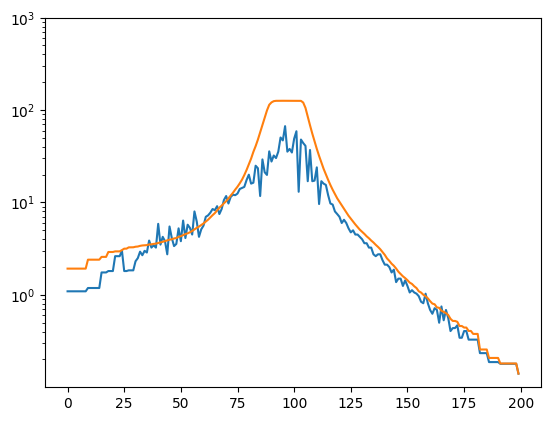

In [ ]:
eps = 1e-7
rat = rads[-1] * jnp.sqrt(jnp.abs(eigvals[-1]))

plt.plot(rads)
plt.plot(rat/jnp.sqrt(eps + jnp.abs(eigvals[idx])))
plt.yscale('log')
plt.ylim(top=1e3)
plt.show()

In [270]:
estimates_300, diffs_300 = get_estimates_preconditioned(300)

100%|██████████| 300/300 [00:29<00:00, 10.29it/s]


In [272]:
estimates_300_pre, diffs_300_pre = get_estimates_preconditioned(300, P_spec)

100%|██████████| 300/300 [00:52<00:00,  5.69it/s]


In [79]:
center = final_params.raveled

idx = logspace_indices(evals.shape[0], 200)
rads = []
rads_neg = []
deltas = []
for i in tqdm(idx):
    vec = P[:, i]
    rad, delta = find_radius(center, vec, cutoff=1e-3, fn=loss_fn, iters=100, rtol=1e-2)
    rad_neg, delta_neg = find_radius(center, -vec, cutoff=1e-3, fn=loss_fn, iters=100, rtol=1e-2)
    rads.append(rad)
    rads_neg.append(rad_neg)
    deltas.append(delta)
    deltas.append(delta_neg)
rads = jnp.array(rads)
rads_neg = jnp.array(rads_neg)
deltas = jnp.array(deltas)

100%|██████████| 200/200 [00:54<00:00,  3.67it/s]


## ADAM preconditioner

In [210]:
adam_state, schedule_state = state.opt_state

In [211]:
mu, nu = adam_state.mu['p'], adam_state.nu['p']
mu.shape, nu.shape

((4810,), (4810,))

In [207]:
def tf_diagH(diagH, eps=1e-3):
    return 1 / (jnp.sqrt(jnp.abs(diagH)) + eps)

In [208]:
diagH = jnp.diag(H)
p = tf_diagH(diagH)
logp = jnp.log(p)
logp_norm = logp - jnp.mean(logp)
p = jnp.exp(logp_norm)
P_diagH = jnp.diag(p)

In [212]:
p = 1 / (jnp.sqrt(jnp.abs(mu)) + 1e-3)
logp = jnp.log(p)
logp_norm = logp - jnp.mean(logp)
p = jnp.exp(logp_norm)
P_mu = jnp.diag(p)

In [213]:
p = 1 / (jnp.sqrt(nu) + 1e-3)
logp = jnp.log(p)
logp_norm = logp - jnp.mean(logp)
p = jnp.exp(logp_norm)
P_nu = jnp.diag(p)

In [35]:
def scaled_diag_preconditioner(spec, scale=0.5, eps=1e-3):
    h_est = jnp.abs(spec)**scale
    p = 1 / (h_est + eps)
    logp = jnp.log(p)
    logp_norm = logp - jnp.mean(logp)
    p = jnp.exp(logp_norm)
    P_scale = jnp.diag(p)
    return P_scale

In [36]:
buffers = [mu, nu]
def scaled_adam_preconditioner(scale=0.5, eps=1e-3, order=1):
    return scaled_diag_preconditioner(buffers[order-1], scale=scale, eps=eps)

In [37]:
myP = scaled_adam_preconditioner(scale=0.2, eps=1e-20, order=2)
print(jnp.linalg.slogdet(myP))
z = jax.random.normal(jax.random.PRNGKey(0), (param_dim))
z = z / jnp.linalg.norm(z)
x = myP @ z
jnp.max(x)

jnp.max(x), loss_fn(final_params.raveled - x), loss_fn(final_params.raveled), loss_fn(final_params.raveled + x)
P_scaled_diagH = scaled_diag_preconditioner(diagH, scale=0.2, eps=1e-20)
print(jnp.linalg.slogdet(P_scaled_diagH))

SlogdetResult(sign=Array(1., dtype=float32), logabsdet=Array(-0.00244141, dtype=float32))


SlogdetResult(sign=Array(1., dtype=float32), logabsdet=Array(-0.00170898, dtype=float32))

In [157]:
z = jax.random.normal(jax.random.PRNGKey(0), (param_dim))
z = z / jnp.linalg.norm(z)
x = P_scaled_diagH @ z
jnp.max(x)

jnp.max(x), loss_fn(final_params.raveled - x), loss_fn(final_params.raveled), loss_fn(final_params.raveled + x)

(Array(1.5838348e+14, dtype=float32),
 Array(2.3391548e+28, dtype=float32),
 Array(0.0008017, dtype=float32),
 Array(1.309635e+28, dtype=float32))

In [345]:
estimates = my_results[0] / jnp.log(10)
estimates.max(), estimates.min(), estimates.mean()

(Array(14838.531, dtype=float32),
 Array(12752.647, dtype=float32),
 Array(13821.216, dtype=float32))

In [370]:
all_results = []
all_results2 = []
scales = jnp.linspace(0.03, 0.3, 11)
eps = 1e-38
n_iters = 10
for scale in tqdm(scales):
    results = get_estimates_preconditioned(n_iters, scaled_adam_preconditioner(scale=scale, eps=eps), show_progress=False)
    all_results.append(results)
    results2 = get_estimates_preconditioned(n_iters, scaled_adam_preconditioner(scale=scale, order=2, eps=eps), show_progress=False)
    all_results2.append(results2)
all_results = jnp.array(all_results)
all_results2 = jnp.array(all_results2)

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:44<00:00,  4.06s/it]


### Experiments

In [ ]:
my_results = get_estimates_preconditioned(10, scaled_adam_preconditioner(scale=0.2, eps=1e-50, order=2), show_progress=False)

KeyboardInterrupt: 

### Plots etc

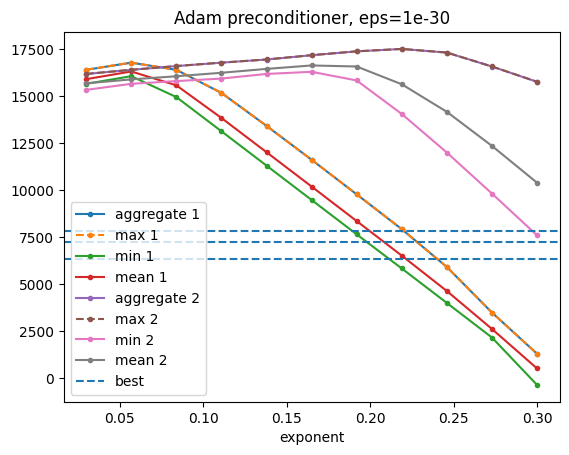

In [371]:
all_estimates_10 = all_results[:, 0] / jnp.log(10)
all_estimates_10_2 = all_results2[:, 0] / jnp.log(10)

for i, all_estimates in enumerate([all_estimates_10, all_estimates_10_2]):   
    aggregates = jnp.array([aggregate(results) for results in all_estimates])
    maxes = jnp.array([jnp.max(results) for results in all_estimates])
    mins = jnp.array([jnp.min(results) for results in all_estimates])
    means = jnp.array([jnp.mean(results) for results in all_estimates])

    plt.plot(scales, aggregates, '.-', label=f'aggregate {i+1}')
    plt.plot(scales, maxes, '.--', label=f'max {i+1}')
    plt.plot(scales, mins, '.-', label=f'min {i+1}')
    plt.plot(scales, means, '.-', label=f'mean {i+1}')

# plt.axvline(0.5, color='black', linestyle='--')

plt.axhline(jnp.min(estimates_300_pre) / jnp.log(10), linestyle='--', label='best')
plt.axhline(jnp.max(estimates_300_pre) / jnp.log(10), linestyle='--')
plt.axhline(jnp.mean(estimates_300_pre) / jnp.log(10), linestyle='--')

plt.legend()
plt.xlabel('exponent')
plt.title(f"Adam preconditioner, eps=1e-30")
plt.show()

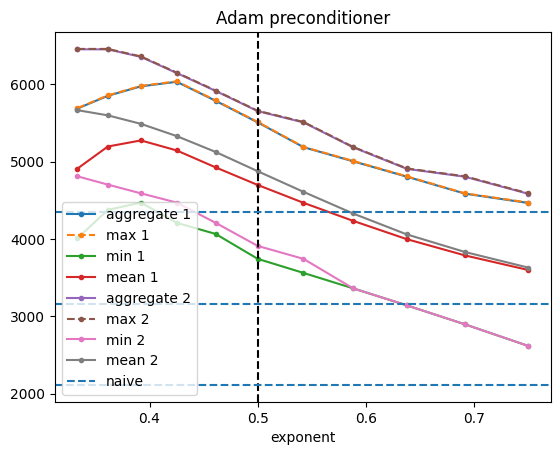

In [372]:
all_results_eps = []
all_results2_eps = []
epses = logspace(1e-39, 1e-30, 10)
scale = 0.06
n_iters = 10
for eps in tqdm(epses):
    results = get_estimates_preconditioned(n_iters, scaled_adam_preconditioner(scale=scale, eps=eps), show_progress=False)
    all_results_eps.append(results)
    results2 = get_estimates_preconditioned(n_iters, scaled_adam_preconditioner(scale=scale, eps=eps, order=2), show_progress=False)
    all_results2_eps.append(results2)
all_results_eps = jnp.array(all_results_eps)
all_results2_eps = jnp.array(all_results2_eps)

100%|██████████| 10/10 [01:10<00:00,  7.02s/it]


In [329]:
all_estimates_10_2[0]

Array([11149.885, 11149.885, 10870.943, 12248.871, 11710.276, 11583.634,
       10199.961, 10231.375, 11710.276, 11583.634], dtype=float32)

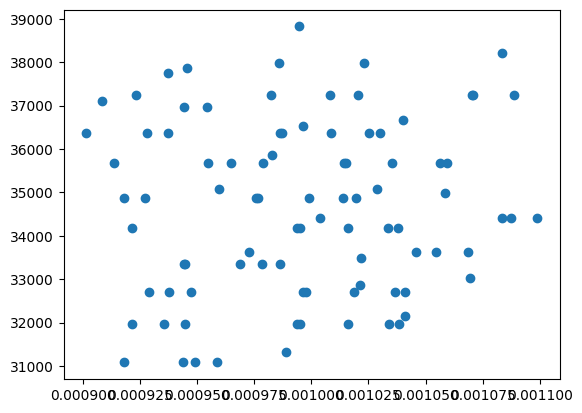

In [390]:
plt.scatter(all_results_eps[:, 1], all_results_eps[:, 0])

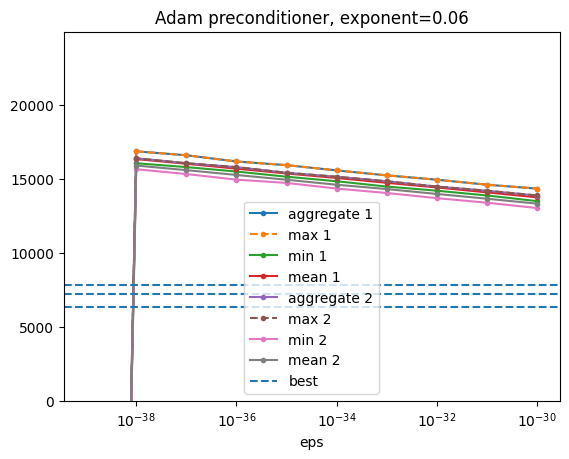

In [374]:
all_estimates_10 = all_results_eps[:, 0] / jnp.log(10)
all_estimates_10_2 = all_results2_eps[:, 0] / jnp.log(10)

for i, all_estimates in enumerate([all_estimates_10, all_estimates_10_2]):   
    aggregates = jnp.array([aggregate(results) for results in all_estimates])
    maxes = jnp.array([jnp.max(results) for results in all_estimates])
    mins = jnp.array([jnp.min(results) for results in all_estimates])
    means = jnp.array([jnp.mean(results) for results in all_estimates])

    plt.plot(epses, aggregates, '.-', label=f'aggregate {i+1}')
    plt.plot(epses, maxes, '.--', label=f'max {i+1}')
    plt.plot(epses, mins, '.-', label=f'min {i+1}')
    plt.plot(epses, means, '.-', label=f'mean {i+1}')

# plt.axvline(1e-3, color='black', linestyle='--')

plt.axhline(jnp.min(estimates_300_pre) / jnp.log(10), linestyle='--', label='best')
plt.axhline(jnp.max(estimates_300_pre) / jnp.log(10), linestyle='--')
plt.axhline(jnp.mean(estimates_300_pre) / jnp.log(10), linestyle='--')

plt.legend()
plt.xlabel('eps')
plt.xscale('log')
plt.ylim(bottom=0)
plt.title("Adam preconditioner, exponent=0.06")
plt.show()

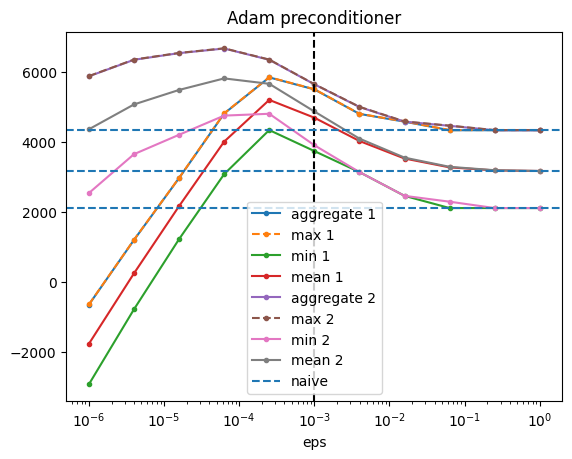

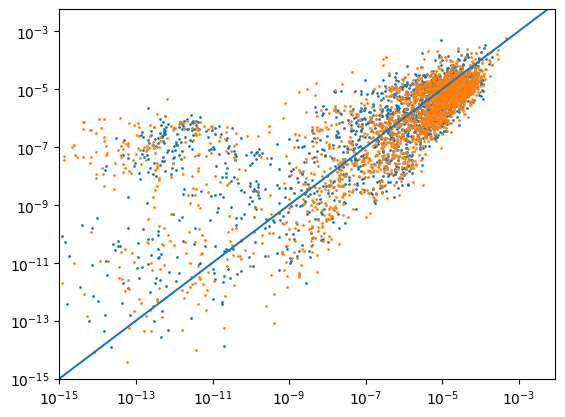

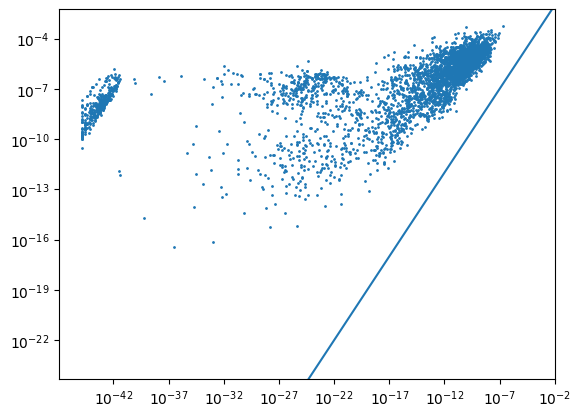

In [80]:

plt.scatter(mu, nu, alpha=1, s=1)
plt.scatter(-mu, nu, alpha=1, s=1)
plt.yscale('log')
plt.xscale('log')
plt.xlim(left=1e-15)
plt.ylim(bottom=1e-15)
plt.axline([0, 0], [1, 1])
plt.show()
plt.scatter(mu**2, nu, alpha=1, s=1)
plt.yscale('log')
plt.xscale('log')
plt.axline([0, 0], [1e-4, 1e-4])
plt.show()

In [94]:
vals = jnp.sort(jnp.abs(diagH))[logspace_indices(diagH.shape[0], 100)]

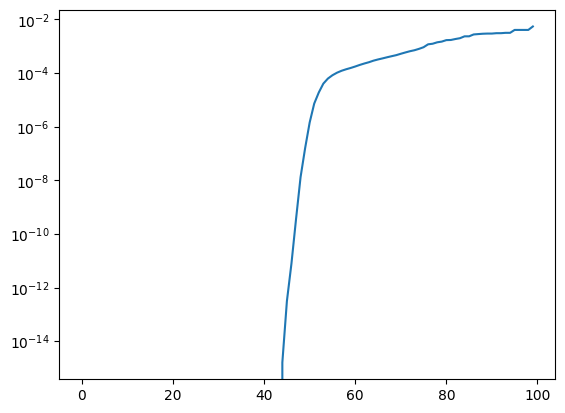

In [96]:
plt.plot(vals)
plt.yscale('log')
plt.show()

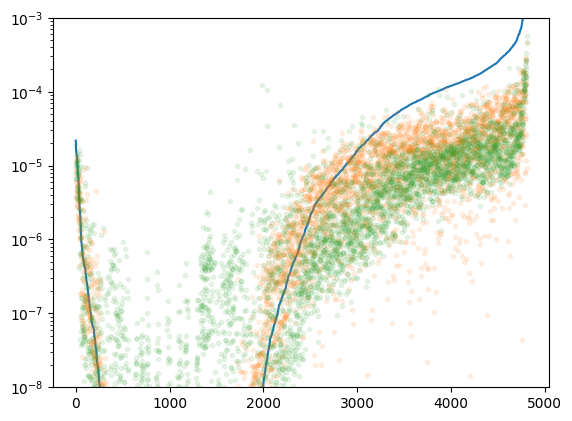

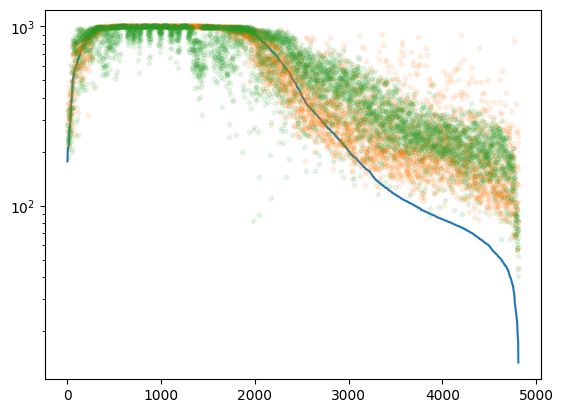

In [117]:
arg = jnp.argsort(diagH)
plt.plot(jnp.abs(diagH)[arg])
plt.plot(jnp.abs(mu)[arg], '.', alpha=0.1)
plt.plot((nu)[arg], '.', alpha=0.1)
plt.yscale('log')
plt.ylim(bottom=1e-8, top=1e-3)
plt.show()

arg = jnp.argsort(diagH)
plt.plot(tf_diagH(diagH)[arg])
plt.plot(tf_diagH(mu)[arg], '.', alpha=0.1)
plt.plot(tf_diagH(nu)[arg], '.', alpha=0.1)
plt.yscale('log')
plt.show()

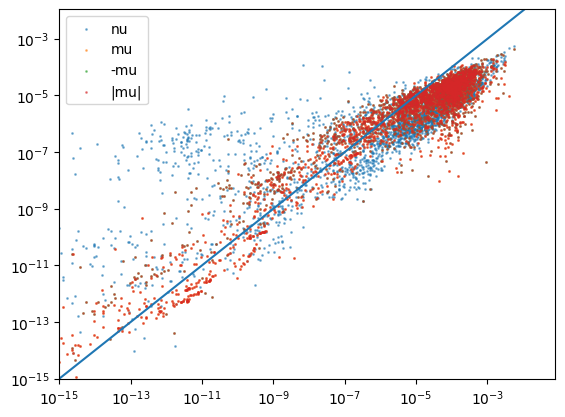

In [131]:
#plt.scatter(diagH, mu, s=1)
plt.scatter(diagH, nu, s=1, alpha=0.5, label='nu')
plt.scatter(diagH, mu, s=1, alpha=0.5, label='mu')
plt.scatter(diagH, -mu, s=1, alpha=0.5, label='-mu')
plt.scatter(diagH, jnp.abs(mu), s=1, alpha=0.5, label='|mu|')
plt.axline([0, 0], [1e-5, 1e-5])
plt.yscale('log')
plt.xscale('log')
plt.ylim(bottom=1e-15)
plt.xlim(left=1e-15)
plt.legend()
plt.show()

## Gaussian init math

In [ ]:
jnp.linalg.norm(final_params.raveled) / jnp.linalg.norm(init_params.raveled)

Array(3.9775472, dtype=float32)

In [60]:
jnp.linalg.norm(final_params.raveled * 8)

Array(273.3976, dtype=float32)

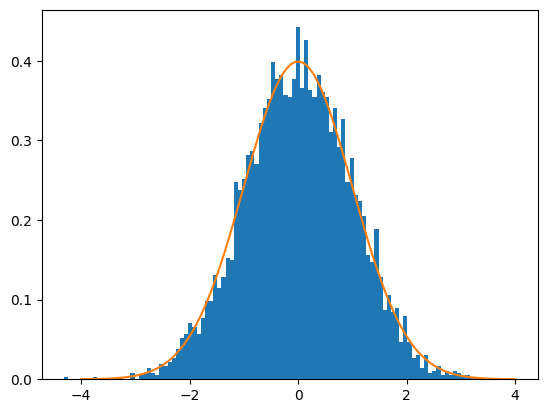

In [58]:
plt.hist(init_params.raveled * 8, bins=100, density=True)
xs = jnp.linspace(-4, 4, 1000)
plt.plot(xs, jnp.exp(-xs**2 / 2) / jnp.sqrt(2 * jnp.pi))
plt.show()

In [150]:
def semifac(n):
    if n % 2 == 0:
        return jnp.prod(jnp.arange(2, n+1, 2))
    else:
        return jnp.prod(jnp.arange(1, n+1, 2))
    
def semifalling(n, k):
    return jnp.prod(jnp.arange(n, k, -2))

In [142]:
jnp.sum(jnp.array([semifalling(n, 32) for n in range(2, 33, 2)]))

Array(inf, dtype=float32)

In [161]:
import scipy as sp

In [171]:
jnp.exp(jax.scipy.special.gammaln(1/2) + ((1/2) - 1) * jnp.log(2))

Array(1.2533152, dtype=float32, weak_type=True)

In [174]:
2/jnp.sqrt(jnp.pi)

Array(1.1283791, dtype=float32, weak_type=True)

In [169]:
jax.scipy.special.gammaln(4810/2) + ((4810/2) - 1) * jnp.log(2)

Array(17982.012, dtype=float32, weak_type=True)

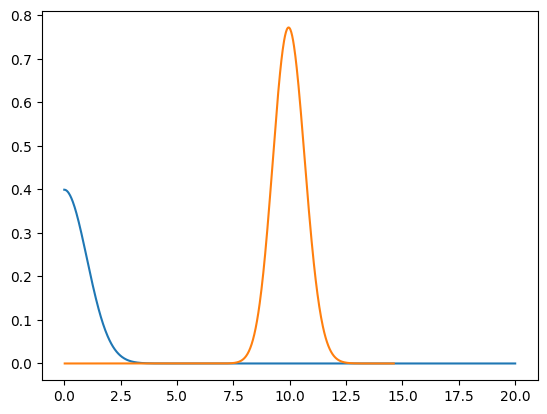

In [124]:

d = 100
xs = jnp.linspace(0, 20, 1000)
plt.plot(xs, jnp.exp(-xs**2 / 2) / jnp.sqrt(2 * jnp.pi))
plt.plot(xs, (xs/d**(.5-.11))**(d) * (xs/d**(.5))**(-1) * jnp.exp(-xs**2 / 2) / jnp.sqrt(2 * jnp.pi))
plt.show()

## Flat directions

In [42]:
z = jax.random.normal(jax.random.PRNGKey(0), (param_dim))
z = z / jnp.linalg.norm(z)
x = P_scaled_diagH @ z
jnp.max(x)

jnp.max(x), loss_fn(final_params.raveled - x), loss_fn(final_params.raveled), loss_fn(final_params.raveled + x)

(Array(1.5838348e+14, dtype=float32),
 Array(2.3391548e+28, dtype=float32),
 Array(0.0008017, dtype=float32),
 Array(1.309635e+28, dtype=float32))

In [47]:
# WRONG
(x**2)[ker_idx].sum()

Array(4.326881e-11, dtype=float32)

In [48]:
(x**2).sum()

Array(1.7405114e+30, dtype=float32)

In [39]:
def get_random_flat_direction(key):
    z = jax.random.normal(key, (param_dim))
    z = z / jnp.linalg.norm(z)
    x = myP @ z
    return x

In [41]:
flat_dict = flatten_dict(final_params.unravel(x))

for k, v in flat_dict.items():
    print(k, v.shape, jnp.linalg.norm(v))

('params', 'Dense_0', 'bias') (64,) 0.004257686
('params', 'Dense_0', 'kernel') (64, 64) 6.3556956e+16
('params', 'Dense_1', 'bias') (10,) 0.0008529342
('params', 'Dense_1', 'kernel') (64, 10) 0.014493892


In [44]:
ker_z = flat_dict[('params', 'Dense_0', 'kernel')]

In [45]:
ker_input = jnp.linalg.norm(ker_z / ker_z.max(), axis=1)
ker_idx = (ker_input > 0.1).nonzero()[0]

### Plots etc

In [ ]:
jnp.linalg.norm(ker_z[10, :])

Array(0.00027683, dtype=float32)

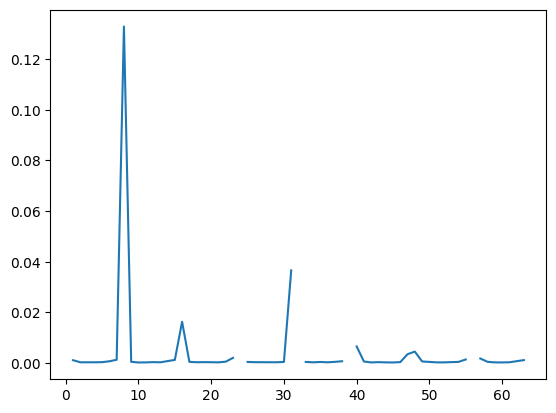

8.224212e+32


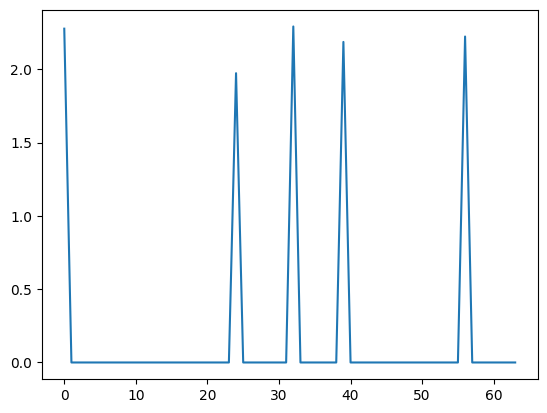

In [ ]:
plt.plot(jnp.linalg.norm(ker_z, axis=1))
plt.show()
print(ker_z.max())
plt.plot(jnp.linalg.norm(ker_z / ker_z.max(), axis=1))
plt.show()

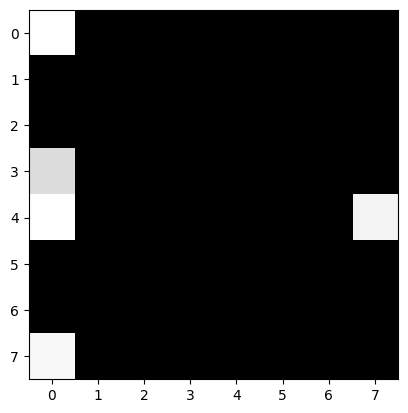

In [ ]:


plt.imshow(ker_input.reshape((8, 8)), cmap='gray')
plt.show()


In [ ]:
jnp.linalg.norm(X_train[:, ker_idx])

Array(0., dtype=float32)

In [ ]:
jnp.linalg.norm(X_test[:, ker_idx])

Array(0.10825317, dtype=float32)

In [ ]:
digits_splits = list(get_digits_splits(jax.random.key(cfg.seed), [-1]))
X_all, Y_all = digits_splits[0]

In [ ]:
ker_idx

Array([ 0, 24, 32, 39, 56], dtype=int32)

In [ ]:
(jnp.sum(X_train**2, axis=0) == 0).nonzero()[0]

Array([ 0, 24, 32, 39, 56], dtype=int32)

In [ ]:
(jnp.sum(X_test**2, axis=0) == 0).nonzero()[0]

Array([ 0, 32, 39], dtype=int32)

In [ ]:
(jnp.sum(X_all**2, axis=0) == 0).nonzero()[0]

Array([ 0, 32, 39], dtype=int32)

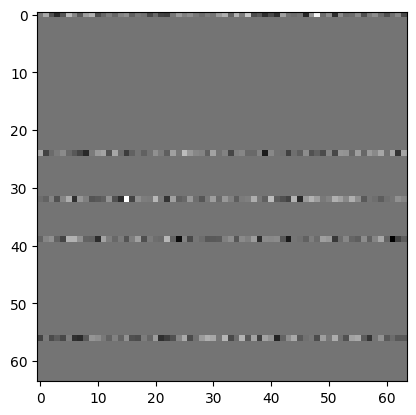

In [ ]:
ker = flat_dict[('params', 'Dense_0', 'kernel')]
ker = ker - ker.min()
ker = ker / ker.max()

plt.imshow(ker, cmap='gray')
plt.show()
# plt.imshow(ker.reshape((8, 8)), cmap='gray')
# plt.show()

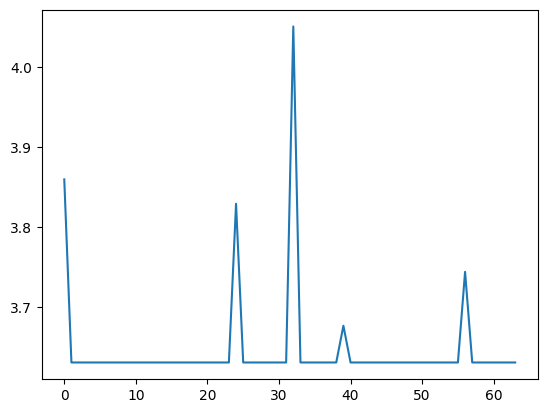

In [ ]:
plt.plot(jnp.linalg.norm(ker, axis=1))
plt.show()

In [ ]:
jnp.linalg.norm(jnp.diag(H)) / jnp.linalg.norm(H)

Array(0.15271802, dtype=float32)

In [ ]:
(jnp.diag(H) == 0).sum()

Array(823, dtype=int32)

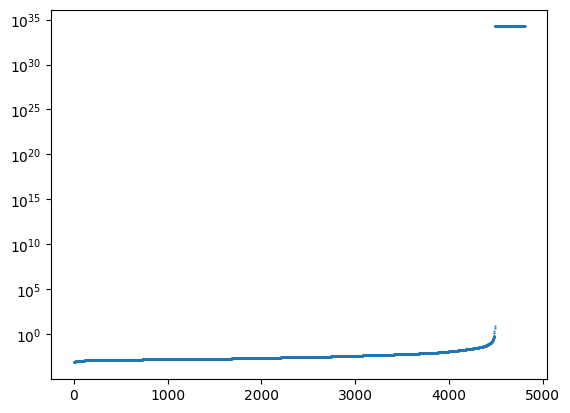

In [ ]:
plt.plot(jnp.sort(jnp.diag(scaled_adam_preconditioner(scale=0.2, eps=1e-38, order=2))), '.', alpha=1, markersize=1)
plt.yscale('log')
plt.show()

## Hutchinson preconditioner

In [239]:
def hutchinson_estimate(H, key, num_samples=100):
    x = jax.random.rademacher(key, (num_samples, H.shape[0]))
    estimates = jnp.einsum('bi,ij,bj->bi', x, H, x)
    return estimates.mean(axis=0)

In [279]:
diagH_hutch = []
for num_samples in 10**jnp.arange(6):
    diagH_hutch.append(hutchinson_estimate(H, jax.random.PRNGKey(0), num_samples))


In [1]:

errors = jnp.array([jnp.linalg.norm(diagH_hutch[i] - jnp.diag(H)) / jnp.linalg.norm(jnp.diag(H)) for i in range(len(diagH_hutch))])
xs = jnp.arange(6)
plt.plot(xs, errors, '.-')
plt.plot(xs, errors[0]/jnp.sqrt(10**xs), '--')
plt.yscale('log')
plt.show()

NameError: name 'jnp' is not defined

## HesScale

In [158]:
def loss_fn_perturbed(params, perturbations, x, y):
    logits, intermediates = model.apply({'params': params, 'perturbations': perturbations}, x, capture_intermediates=True)
    
    loss = sparse_xent(logits, y)
    acts = intermediates['intermediates']

    return loss, acts

In [175]:
def gelu_prime(x):
    return jax.grad(jax.nn.gelu)(x)

def gelu_prime2(x):
    return jax.grad(gelu_prime)(x)


def gelu_prime_vec(x):
    return jax.vmap(gelu_prime)(x.reshape(-1)).reshape(x.shape)

def gelu_prime2_vec(x):
    return jax.vmap(gelu_prime2)(x.reshape(-1)).reshape(x.shape)


In [191]:
def hesscale(params_unraveled):

    params = params_unraveled['params']

    variables = model.init(jax.random.key(0), X_train[0])
    params_new = variables['params'] # for later
    perturbations = variables['perturbations']
    grads, acts = jax.jacfwd(loss_fn_perturbed, argnums=1, has_aux=True)(params, perturbations, X_train, Y_train)

    d2_ker_est = {}
    d2_bias_est = {}
    d2_act_est = {}

    # second layer

    # [b, d]
    a_0 = acts['Dense_0']['__call__'][0]
    h_0 = jax.nn.gelu(a_0)

    # [b, 10]
    a_1 = acts['Dense_1']['__call__'][0]
    logits = a_1

    # [d, d]
    ker_0 = params['Dense_0']['kernel']

    # [d, 10]
    ker_1 = params['Dense_1']['kernel']

    # [b, 10]
    probs = jax.nn.softmax(logits, axis=-1)

    # [b, 10]
    d2_act_est[1] = probs - probs**2

    # [d, 10]
    d2_ker_est[1] = jnp.einsum('bi,bj,bj->ji',
                            d2_act_est[1],
                            h_0,
                            h_0) / h_0.shape[0]

    # [10]
    d2_bias_est[1] = d2_act_est[1].mean(axis=0)


    # first layer

    # [b, d]
    gelu_prime_a_0 = gelu_prime_vec(a_0)
    gelu_prime2_a_0 = gelu_prime2_vec(a_0)

    # [b, d]
    d2_act_est[0] = jnp.einsum(
        'bi,bi,bj,ij,ij->bi',
        gelu_prime_a_0,
        gelu_prime_a_0,
        d2_act_est[1],
        ker_1,
        ker_1
    ) + jnp.einsum(
        'bi,bj,ij->bi',
        gelu_prime2_a_0,
        grads['a_L'],
        ker_1
    )

    # [d, d]
    d2_ker_est[0] = jnp.einsum('bi,bj,bj->ji', 
                            d2_act_est[0],
                            X_train,
                            X_train) / X_train.shape[0]

    # [d]
    d2_bias_est[0] = d2_act_est[0].mean(axis=0)

    estimates = params_new
    estimates['Dense_0']['kernel'] = d2_ker_est[0]
    estimates['Dense_0']['bias'] = d2_bias_est[0]
    estimates['Dense_1']['kernel'] = d2_ker_est[1]
    estimates['Dense_1']['bias'] = d2_bias_est[1]

    return estimates


In [194]:
est = hesscale(final_params.unraveled)
diagH_hesscale =mlp.Params(est).raveled

## Various preconditioners

In [252]:
def scaled_diag_preconditioner(spec, scale=0.5, eps=1e-3):
    h_est = jnp.abs(spec)**scale
    p = 1 / (h_est + eps)
    logp = jnp.log(p)
    logp_norm = logp - jnp.mean(logp)
    p = jnp.exp(logp_norm)
    P_scale = jnp.diag(p)
    return P_scale

In [155]:
results_300_newton = get_estimates_preconditioned(300, newton=True)

100%|██████████| 300/300 [00:30<00:00,  9.69it/s]


In [156]:
results_300 = get_estimates_preconditioned(300, newton=False)

100%|██████████| 300/300 [00:31<00:00,  9.49it/s]


In [159]:
results_3k_vectorized = get_estimates_vectorized(3000)

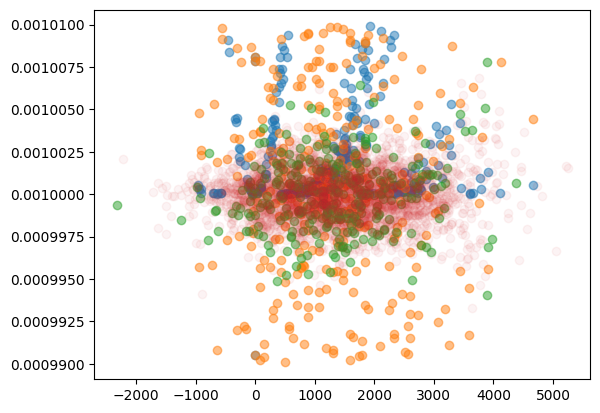

In [161]:
plt.scatter(*results_300_newton, alpha=0.5)
plt.scatter(*results_300, alpha=0.5)
plt.scatter(*results_300_vectorized, alpha=0.5)
plt.scatter(*results_3k_vectorized, alpha=0.05)
plt.show()


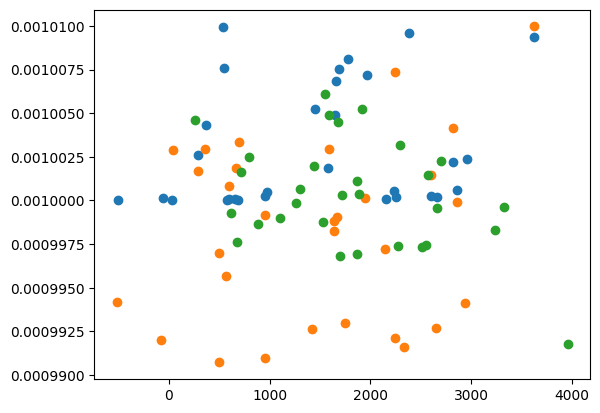

In [153]:
plt.scatter(*results_30_newton)
plt.scatter(*results_30)
plt.scatter(*results_30_vectorized)
plt.show()


In [258]:
results_300 = get_estimates_preconditioned(300)

100%|██████████| 300/300 [00:27<00:00, 11.03it/s]


In [257]:
results_300_pre = get_estimates_preconditioned(300, P_spec)

100%|██████████| 300/300 [00:53<00:00,  5.59it/s]


In [253]:
P_diagH = scaled_diag_preconditioner(diagH)
results_300_diagH = get_estimates_preconditioned(300, P_diagH)

100%|██████████| 300/300 [00:40<00:00,  7.45it/s]


In [259]:
P_hesscale = scaled_diag_preconditioner(diagH_hesscale)
results_300_hesscale = get_estimates_preconditioned(300, P_hesscale)

100%|██████████| 300/300 [00:39<00:00,  7.65it/s]


In [274]:
results_300_mu = get_estimates_preconditioned(300, P_mu)
results_300_nu = get_estimates_preconditioned(300, P_nu)

100%|██████████| 300/300 [00:36<00:00,  8.15it/s]


In [281]:
P_hutch_100k = scaled_diag_preconditioner(diagH_hutch[5])
P_hutch_10k = scaled_diag_preconditioner(diagH_hutch[4])
P_hutch_1k = scaled_diag_preconditioner(diagH_hutch[3])
P_hutch_100 = scaled_diag_preconditioner(diagH_hutch[2])
P_hutch_10 = scaled_diag_preconditioner(diagH_hutch[1])
P_hutch_1 = scaled_diag_preconditioner(diagH_hutch[0])

In [265]:

results_300_hutch_100k = get_estimates_preconditioned(300, P_hutch_100k)
results_300_hutch_1k = get_estimates_preconditioned(300, P_hutch_1k)


100%|██████████| 300/300 [00:39<00:00,  7.58it/s]


In [277]:

results_300_hutch_10 = get_estimates_preconditioned(300, P_hutch_10)


100%|██████████| 300/300 [00:41<00:00,  7.21it/s]


In [282]:
results_300_hutch_1 = get_estimates_preconditioned(300, P_hutch_1)


100%|██████████| 300/300 [00:43<00:00,  6.88it/s]


In [123]:
def scaled_preconditioner(scale=0.5, eps=1e-3):
    p = 1 / ((jnp.abs(evals))**scale + eps)
    logp = jnp.log(p)
    logp_norm = logp - jnp.mean(logp)
    p = jnp.exp(logp_norm)
    P_weak = jnp.einsum('ij,j->ij', evecs, p)

    P_weak = P_weak / jnp.exp(jnp.linalg.slogdet(P_weak).logabsdet / P_weak.shape[0])
    return P_weak

In [135]:
results_300_weak = get_estimates_preconditioned(300, scaled_preconditioner(0.25))

100%|██████████| 300/300 [00:46<00:00,  6.47it/s]


In [141]:
results_300_scale40 = get_estimates_preconditioned(300, scaled_preconditioner(0.4))

100%|██████████| 300/300 [00:48<00:00,  6.19it/s]


In [142]:
results_300_scale60 = get_estimates_preconditioned(300, scaled_preconditioner(0.6))

100%|██████████| 300/300 [00:38<00:00,  7.76it/s]


### Plots etc

In [271]:
param_dim * jnp.log10(norm(final_params.raveled))

Array(5940.924, dtype=float32)

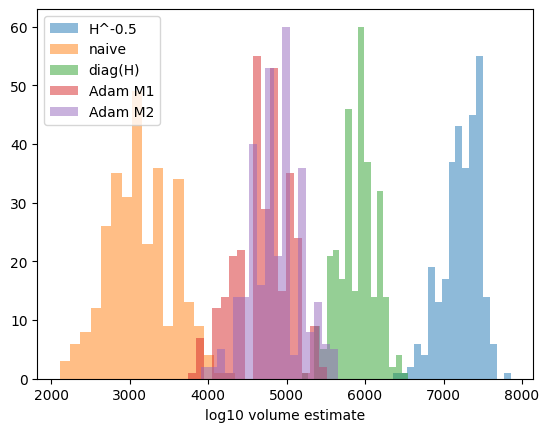

In [290]:
nbins = int(jnp.sqrt(300))
plt.hist(estimates_300_pre / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.hist(estimates_300 / jnp.log(10), bins=nbins, alpha=0.5, label="naive")
plt.hist(results_300_diagH[0] / jnp.log(10), bins=nbins, alpha=0.5, label="diag(H)")
plt.hist(results_300_mu[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Adam M1")
plt.hist(results_300_nu[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Adam M2")
#plt.hist(results_300_hutch_100k[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Hutch 100k")
#plt.hist(results_300_hutch_1k[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Hutch 1k")
plt.xlabel("log10 volume estimate")
plt.legend()
plt.show()

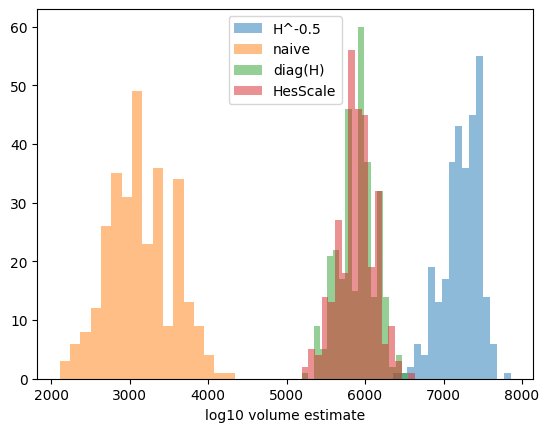

In [260]:
nbins = int(jnp.sqrt(300))
plt.hist(results_300_pre[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.hist(results_300[0] / jnp.log(10), bins=nbins, alpha=0.5, label="naive")
plt.hist(results_300_diagH[0] / jnp.log(10), bins=nbins, alpha=0.5, label="diag(H)")
plt.hist(results_300_hesscale[0] / jnp.log(10), bins=nbins, alpha=0.5, label="HesScale")
plt.xlabel("log10 volume estimate")
plt.legend()
plt.show()

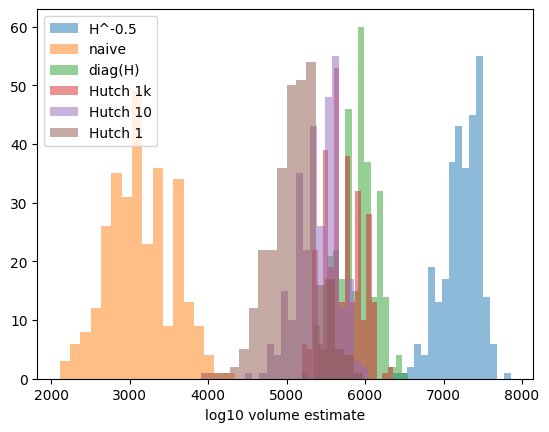

In [293]:
nbins = int(jnp.sqrt(300))
plt.hist(estimates_300_pre / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.hist(estimates_300 / jnp.log(10), bins=nbins, alpha=0.5, label="naive")
plt.hist(results_300_diagH[0] / jnp.log(10), bins=nbins, alpha=0.5, label="diag(H)")
# plt.hist(results_300_mu[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Adam M1")
# plt.hist(results_300_nu[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Adam M2")
#plt.hist(results_300_hutch_100k[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Hutch 100k")
plt.hist(results_300_hutch_1k[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Hutch 1k")
plt.hist(results_300_hutch_10[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Hutch 10")
plt.hist(results_300_hutch_1[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Hutch 1")
plt.xlabel("log10 volume estimate")
plt.legend()
plt.show()

In [145]:
all_results = []
for scale in tqdm(logspace(0.25, 1.0, 11)):
    results = get_estimates_preconditioned(300, scaled_preconditioner(scale), show_progress=False)
    all_results.append(results)
all_results = jnp.array(all_results)

100%|██████████| 11/11 [07:42<00:00, 42.05s/it]


In [158]:
all_results_eps = []
for eps in tqdm(logspace(1e-6, 1, 11)):
    results = get_estimates_preconditioned(300, scaled_preconditioner(0.5, eps), show_progress=False)
    all_results_eps.append(results)
all_results_eps = jnp.array(all_results_eps)

100%|██████████| 11/11 [06:39<00:00, 36.34s/it]


In [149]:
aggregate(all_results[0][0])

Array(13020.018, dtype=float32)

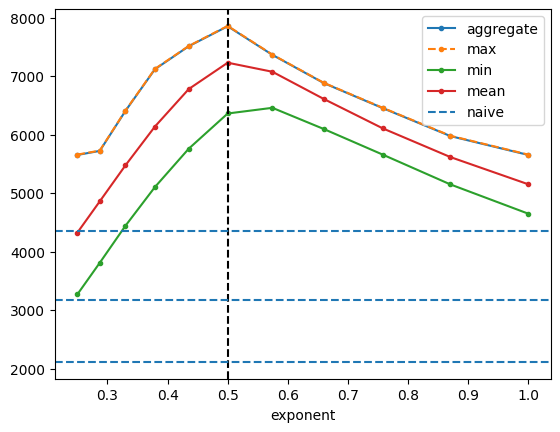

In [163]:
nbins = int(jnp.sqrt(300))
scales = logspace(0.25, 1.0, 11)
all_estimates_10 = all_results[:, 0] / jnp.log(10)
aggregates = jnp.array([aggregate(results) for results in all_estimates_10])
maxes = jnp.array([jnp.max(results) for results in all_estimates_10])
mins = jnp.array([jnp.min(results) for results in all_estimates_10])
means = jnp.array([jnp.mean(results) for results in all_estimates_10])
plt.plot(scales, aggregates, '.-', label='aggregate')
plt.plot(scales, maxes, '.--', label='max')
plt.plot(scales, mins, '.-', label='min')
plt.plot(scales, means, '.-', label='mean')
plt.axvline(0.5, color='black', linestyle='--')
plt.axhline(jnp.min(estimates_300) / jnp.log(10), linestyle='--', label='naive')
plt.axhline(jnp.max(estimates_300) / jnp.log(10), linestyle='--')
plt.axhline(jnp.mean(estimates_300) / jnp.log(10), linestyle='--')
plt.legend()
plt.xlabel('exponent')
plt.show()

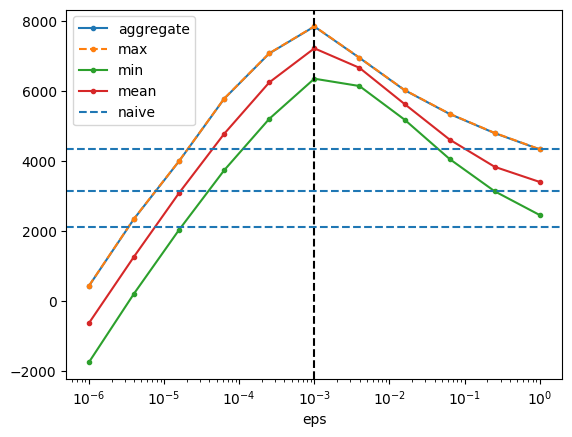

In [165]:
nbins = int(jnp.sqrt(300))
epses = logspace(1e-6, 1, 11)
all_estimates_10 = all_results_eps[:, 0] / jnp.log(10)
aggregates = jnp.array([aggregate(results) for results in all_estimates_10])
maxes = jnp.array([jnp.max(results) for results in all_estimates_10])
mins = jnp.array([jnp.min(results) for results in all_estimates_10])
means = jnp.array([jnp.mean(results) for results in all_estimates_10])
plt.plot(epses, aggregates, '.-', label='aggregate')
plt.plot(epses, maxes, '.--', label='max')
plt.plot(epses, mins, '.-', label='min')
plt.plot(epses, means, '.-', label='mean')
plt.axvline(1e-3, color='black', linestyle='--')
plt.axhline(jnp.min(estimates_300) / jnp.log(10), linestyle='--', label='naive')
plt.axhline(jnp.max(estimates_300) / jnp.log(10), linestyle='--')
plt.axhline(jnp.mean(estimates_300) / jnp.log(10), linestyle='--')
plt.legend()
plt.xscale('log')
plt.xlabel('eps')
plt.show()

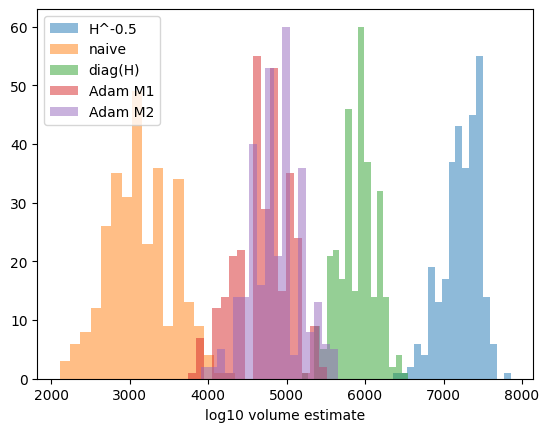

In [140]:
nbins = int(jnp.sqrt(300))
plt.hist(estimates_300_pre / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.hist(estimates_300 / jnp.log(10), bins=nbins, alpha=0.5, label="naive")
plt.hist(results_300_diagH[0] / jnp.log(10), bins=nbins, alpha=0.5, label="diag(H)")
plt.hist(results_300_mu[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Adam M1")
plt.hist(results_300_nu[0] / jnp.log(10), bins=nbins, alpha=0.5, label="Adam M2")
# plt.hist(results_300_weak[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.25")
# plt.hist(results_300_scale40[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.4")
# plt.hist(results_300_scale60[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.6")
plt.xlabel("log10 volume estimate")
plt.legend()
plt.show()

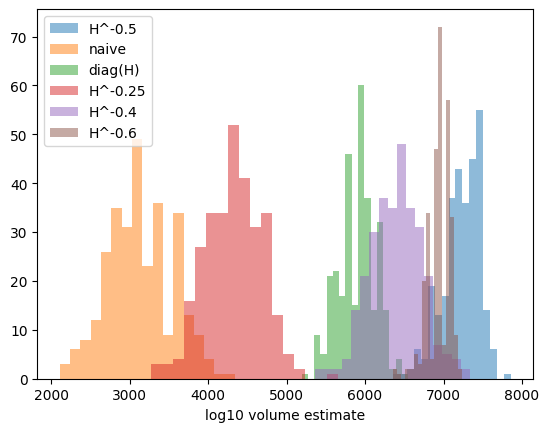

In [ ]:
nbins = int(jnp.sqrt(300))
plt.hist(estimates_300_pre / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.5")
plt.hist(estimates_300 / jnp.log(10), bins=nbins, alpha=0.5, label="naive")
plt.hist(results_300_diagH[0] / jnp.log(10), bins=nbins, alpha=0.5, label="diag(H)")
plt.hist(results_300_weak[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.25")
plt.hist(results_300_scale40[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.4")
plt.hist(results_300_scale60[0] / jnp.log(10), bins=nbins, alpha=0.5, label="H^-0.6")
plt.xlabel("log10 volume estimate")
plt.legend()
plt.show()

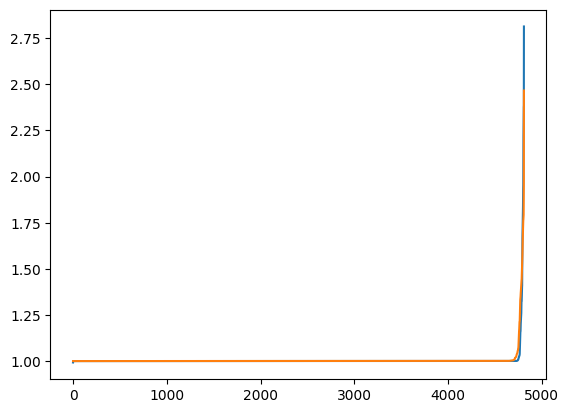

In [ ]:
plt.plot(jnp.sort(jnp.linalg.norm(evecs, axis=0)))
plt.plot(jnp.sort(jnp.linalg.norm(evecs.T, axis=0)))
#plt.yscale('log')
plt.show()

In [30]:
estimates_100k = jnp.load('estimates_100000.npy')
diffs_100k = jnp.load('diffs_100000.npy')
estimates_100k_pre = jnp.load('estimates_preconditioned_100000.npy')
diffs_100k_pre = jnp.load('diffs_preconditioned_100000.npy')

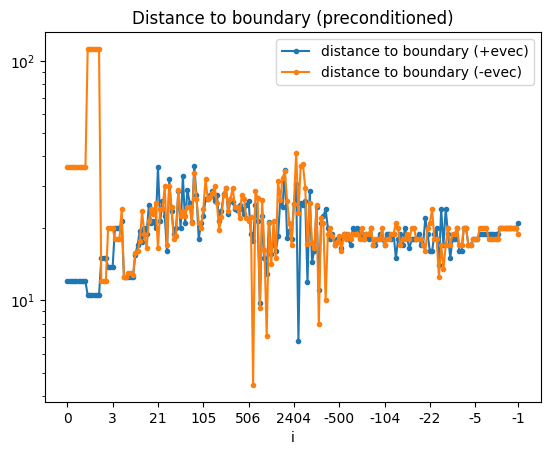

In [82]:
param_dim = final_params.raveled.shape[0]
plt.plot(rads, '.-', label='distance to boundary (+evec)')
plt.plot(rads_neg, '.-', label='distance to boundary (-evec)')
plt.yscale('log')
# plt.ylim(top=1e3)
plt.legend()
plt.title('Distance to boundary (preconditioned)')
plt.xlabel('i')
# change x labels to idx
tick_spacing = 20
plt.xticks(list(range(0, len(idx), tick_spacing)) + [len(idx) - 1], 
           [(f'{i - param_dim}' if i > param_dim//2 else f'{i}') 
            for i in idx[::tick_spacing]] + [f'{idx[-1] - param_dim}'])
plt.show()

In [162]:
estimates_220k = jnp.load('estimates_220k1.npy')
estimates_220k_g = jnp.load('estimates_220k1g.npy')
estimates_220k_pre = jnp.load('estimates_preconditioned_220k1.npy')

In [150]:
def h_from_logvol(logvol):
    lograd = logvol / final_params.raveled.shape[0]
    rad = jnp.exp(lograd)
    return 1 / rad**2

In [145]:
jnp.max(jnp.abs(estimates_220k-estimates_220k_g))

Array(0., dtype=float32)

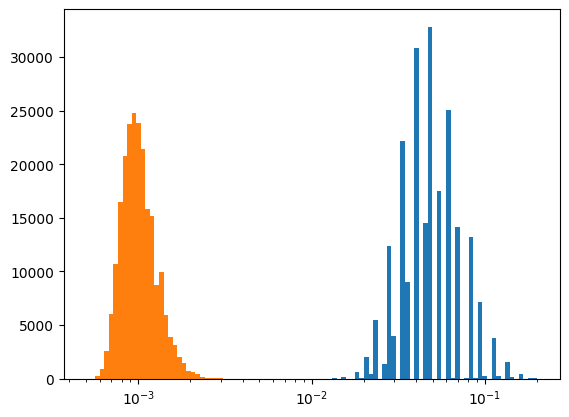

In [185]:
bins = logspace(5e-4, 2e-1, 100)
plt.hist(h_from_logvol(estimates_220k), bins=bins)
plt.hist(h_from_logvol(estimates_220k_pre), bins=bins)
plt.xscale('log')
plt.show()

In [154]:
jax.scipy.stats

<module 'jax.scipy.stats' from '/home/adam/.conda/envs/jax311/lib/python3.11/site-packages/jax/scipy/stats/__init__.py'>

In [156]:
import scipy.stats as stats

In [166]:
def bootstrap_cumulants(estimates, k, n_bootstraps=1000):
    hs = h_from_logvol(estimates)
    hs = hs / jnp.mean(hs)
    cumulants = []
    for i in range(n_bootstraps):
        bootstrap_hs = jax.random.choice(jax.random.key(cfg.seed), hs, (len(hs),), replace=True)
        cumulants.append(stats.kstat(bootstrap_hs, k))
    return cumulants

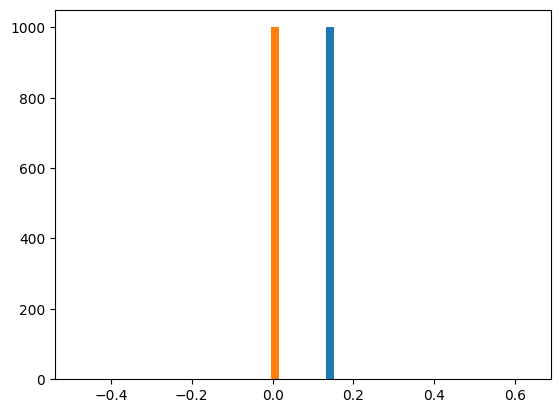

In [169]:
plt.hist(bootstrap_cumulants(estimates_220k, 4), bins=50)
plt.hist(bootstrap_cumulants(estimates_220k_pre, 4), bins=50)
plt.show()

In [170]:
def HK_from_hK(hK1, hK2, hK3, hK4):
    HM1 = hK1
    HM2 = hK2 / 2
    HM3 = hK3 / 8
    HM4 = hK4 / 48

    HK1 = HM1
    HK2 = HM2 - HM1**2
    HK3 = HM3 - 3*HM1*HM2 + 2*HM1**3
    HK4 = HM4 - 4*HM1*HM3 - 3*HM2**2 + 12*HM1**2*HM2 - 6*HM1**4
    return HK1, HK2, HK3, HK4

In [174]:
hs = h_from_logvol(estimates_220k)
hs = hs / jnp.mean(hs)

jnp.std(hs)

Array(0.41883582, dtype=float32)

In [175]:
h_from_logvol(estimates_220k).mean()

Array(0.0517944, dtype=float32)

In [173]:
# bootstrap estimates of first 4 cumulants
for estimates in [estimates_220k, estimates_220k_pre]:
    hs = h_from_logvol(estimates)
    hs = hs / jnp.mean(hs)

    hKs = jnp.array([stats.kstat(hs, k) for k in range(1, 5)])
    HKs = HK_from_hK(*hKs)

    for k in range(1, 5):
        print(f"h Cumulant {k}: {hKs[k-1]:.5f}, ^(1/{k}): {hKs[k-1]**(1/k):.5f}")
    for k in range(1, 5):
        print(f"H Cumulant {k}: {HKs[k-1]:.5f}, ^(1/{k}): {HKs[k-1]**(1/k):.5f}")
    print()

h Cumulant 1: 1.00000, ^(1/1): 1.00000
h Cumulant 2: 0.17542, ^(1/2): 0.41884
h Cumulant 3: 0.11442, ^(1/3): 0.48547
h Cumulant 4: 0.13393, ^(1/4): 0.60495
H Cumulant 1: 1.00000, ^(1/1): 1.00000
H Cumulant 2: -0.91229, ^(1/2): nan
H Cumulant 3: 1.75117, ^(1/3): 1.20534
H Cumulant 4: -5.02495, ^(1/4): nan

h Cumulant 1: 1.00000, ^(1/1): 1.00000
h Cumulant 2: 0.06523, ^(1/2): 0.25540
h Cumulant 3: 0.02544, ^(1/3): 0.29409
h Cumulant 4: 0.01683, ^(1/4): 0.36016
H Cumulant 1: 1.00000, ^(1/1): 1.00000
H Cumulant 2: -0.96739, ^(1/2): nan
H Cumulant 3: 1.90534, ^(1/3): 1.23972
H Cumulant 4: -5.62419, ^(1/4): nan



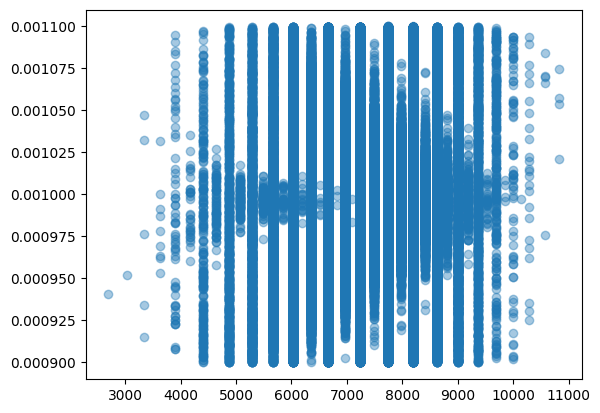

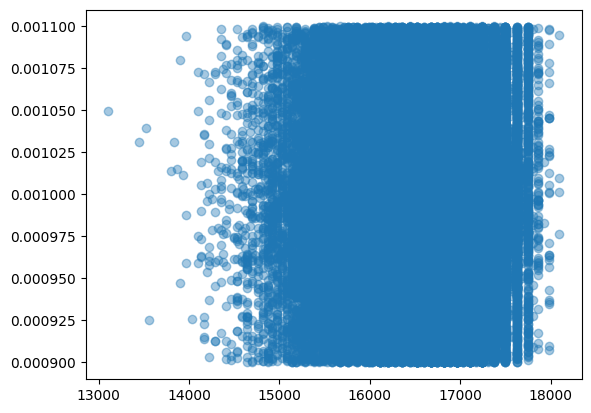

In [32]:
plt.scatter(estimates_100k, diffs_100k, alpha=0.4)
plt.show()
plt.scatter(estimates_100k_pre, diffs_100k_pre, alpha=0.4)
plt.show()

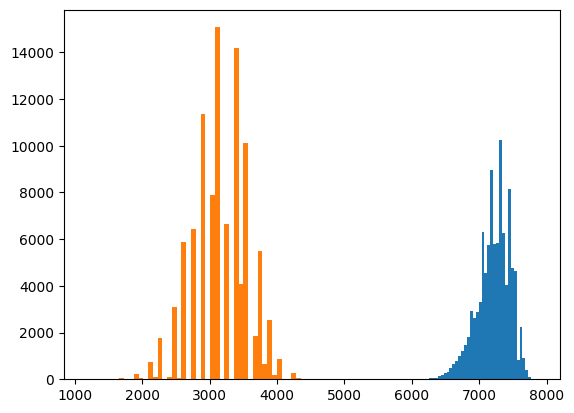

In [37]:
plt.hist(estimates_100k_pre / jnp.log(10), bins=50)
plt.hist(estimates_100k / jnp.log(10), bins=50)
plt.show()

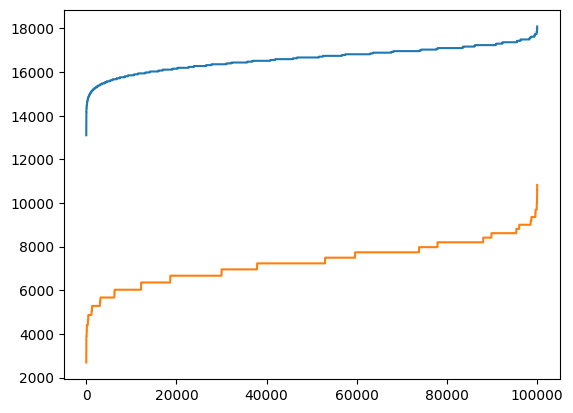

In [38]:
plt.plot(jnp.sort(estimates_100k_pre))
plt.plot(jnp.sort(estimates_100k))
plt.show()

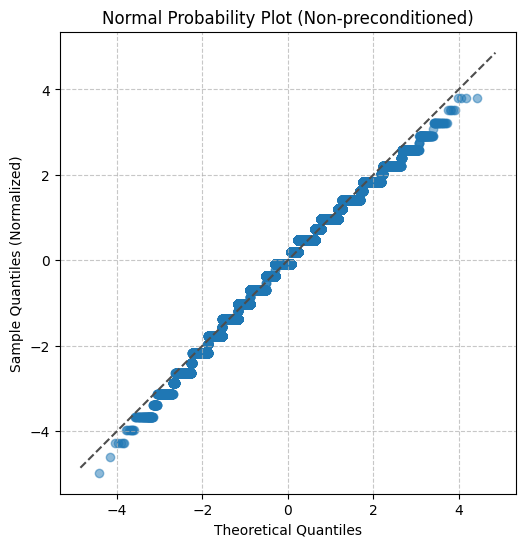

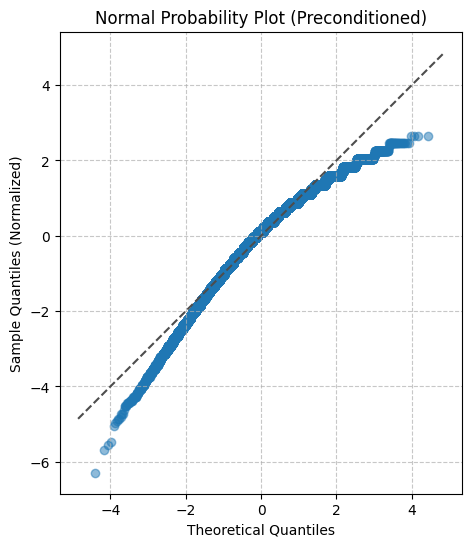

In [51]:
# For the non-preconditioned estimates
fig, ax = normal_probability_plot(estimates_100k, title="Normal Probability Plot (Non-preconditioned)")
# aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# For the preconditioned estimates
fig, ax = normal_probability_plot(estimates_100k_pre, title="Normal Probability Plot (Preconditioned)")
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [59]:
# skewness of estimates

print(stats.skew(estimates_100k))
print(stats.skew(estimates_100k_pre))
print(stats.skew(jax.random.normal(jax.random.key(cfg.seed), (100, 100000)), axis=1).std())

-0.2385307401418686
-0.6633809804916382
0.0072959809006911385


In [32]:
# 300
jnp.mean(estimates_300_pre), jnp.max(estimates_300_pre), jnp.min(estimates_300_pre), aggregate(estimates_300_pre)

(Array(16632.787, dtype=float32),
 Array(18091.373, dtype=float32),
 Array(14644.153, dtype=float32),
 Array(18085.67, dtype=float32))

In [33]:
jnp.sort(estimates_300_pre)[-10:] / jnp.log(10), aggregate(estimates_300_pre) / jnp.log(10)

(Array([7543.051 , 7571.091 , 7571.091 , 7598.7593, 7598.7593, 7598.7593,
        7598.7593, 7598.7593, 7653.0205, 7856.984 ], dtype=float32),
 Array(7854.507, dtype=float32))

In [34]:
jnp.sort(estimates_300)[-10:] / jnp.log(10), aggregate(estimates_300) / jnp.log(10)

(Array([3910.1133, 3910.1133, 3910.1133, 3910.1133, 3988.9512, 4064.9219,
        4064.9219, 4064.9219, 4209.045 , 4343.8633], dtype=float32),
 Array(4341.3857, dtype=float32))

In [38]:
param_dim = final_params.raveled.shape[0]

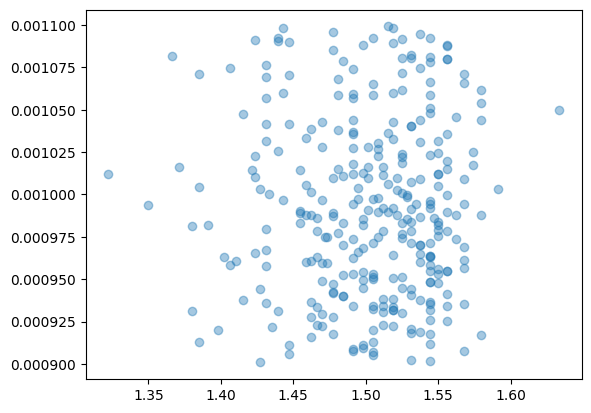

In [39]:
plt.scatter(estimates_300_pre / param_dim / jnp.log(10), diffs_300_pre, alpha=0.4)
plt.show()

In [43]:
jnp.linalg.slogdet(P).logabsdet / jnp.log(10)

Array(5.1438727, dtype=float32)

## logspace indices tests

In [339]:

print(logspace_indices(1000, 10), 999-logspace_indices(1000, 10))
print(logspace_indices(1000, 9), 999-logspace_indices(1000, 9))
print(logspace_indices(999, 10))
print(logspace_indices(999, 9))
print(logspace_indices(998, 10))
print(logspace_indices(998, 9))

[  0   2  11  40 143 499 894 977 995 999] [999 997 988 959 856 500 105  22   4   0]
[  0   3  21 104 499 894 977 995 999] [999 996 978 895 500 105  22   4   0]
[  0   2  11  40 143 498 893 976 994 998]
[  0   3  21 104 498 893 976 994 998]
[  0   2  11  40 143 498 892 975 993 997]
[  0   3  21 104 498 892 975 993 997]


## LR scan

In [195]:
for lr in logspace(.05, .07, 10):
    cfg = SimpleConfig(train_size=1024, opt="adam", lr=lr)
    test_loss, train_loss, state = quick_train()
    print(f"lr: {lr}, test_loss: {test_loss}, train_loss: {train_loss}")
for lr in logspace(.5, .6, 10):
    cfg = SimpleConfig(train_size=1024, opt="sgd", lr=lr)
    test_loss, train_loss, state = quick_train()
    print(f"lr: {lr}, test_loss: {test_loss}, train_loss: {train_loss}")

lr: 0.05000000819563866, test_loss: 0.11548574268817902, train_loss: 0.0015778488013893366
lr: 0.05190467834472656, test_loss: 0.11401877552270889, train_loss: 0.0014272136613726616
lr: 0.05388190224766731, test_loss: 0.11011028289794922, train_loss: 0.0009540490573272109
lr: 0.05593446269631386, test_loss: 0.10658115893602371, train_loss: 0.001021563308313489
lr: 0.058065179735422134, test_loss: 0.10970848053693771, train_loss: 0.000830410048365593
lr: 0.060277096927165985, test_loss: 0.12028402835130692, train_loss: 0.0007267604814842343
lr: 0.06257325410842896, test_loss: 0.12307970225811005, train_loss: 0.0006417390541173518
lr: 0.06495688110589981, test_loss: 0.12391159683465958, train_loss: 0.0008437999058514833
lr: 0.06743130832910538, test_loss: 0.12119339406490326, train_loss: 0.0008967701578512788
lr: 0.07000001519918442, test_loss: 0.12071821093559265, train_loss: 0.0010912426514551044
lr: 0.5, test_loss: 0.11589391529560089, train_loss: 0.00130931893363595
lr: 0.51023226976

#### Train loss

In [213]:
for lr in logspace(.06, .08, 5):
    cfg = SimpleConfig(train_size=1024, opt="adam", lr=lr, num_epochs=1000)
    test_loss, train_loss, state = quick_train()
    print(f"lr: {lr}, train_loss: {train_loss}, test_loss: {test_loss}, ")

lr: 0.06000000238418579, train_loss: 4.090820198143774e-07, test_loss: 0.18191520869731903, 
lr: 0.0644742101430893, train_loss: 2.989538074871234e-07, test_loss: 0.18297605216503143, 
lr: 0.06928203254938126, train_loss: 3.7322635648706637e-07, test_loss: 0.21219408512115479, 
lr: 0.07444837689399719, train_loss: 8.859189648546817e-08, test_loss: 0.4015870988368988, 
lr: 0.08000000566244125, train_loss: 1.4237551226869982e-07, test_loss: 0.370047390460968, 


In [212]:
for num_epochs in logspace(1000, 10000, 3):
    num_epochs = int(num_epochs)
    cfg = SimpleConfig(train_size=1024, opt="adam", lr=0.07, num_epochs=num_epochs)
    test_loss, train_loss, state = quick_train()
    p_norm = jnp.linalg.norm(state.params['p'])
    print(f"num_epochs: {num_epochs}, test_loss: {test_loss}, train_loss: {train_loss}, p_norm: {p_norm}")

num_epochs: 1000, test_loss: 0.29613015055656433, train_loss: 1.208387772066999e-07, p_norm: 72.74116516113281
num_epochs: 3162, test_loss: 0.2837347686290741, train_loss: 1.618172440487342e-08, p_norm: 76.01581573486328
num_epochs: 9999, test_loss: 0.28226032853126526, train_loss: 4.423781785334313e-09, p_norm: 68.90670013427734


#### Test loss

In [67]:
num_epochs = 25
lr = .04
weight_decay = 0.15

for lr in jnp.linspace(.02, .06, 9):
    num_epochs = int(num_epochs)
    my_cfg = SimpleConfig(train_size=1024, 
                          opt="adam", 
                          lr=lr, 
                          num_epochs=num_epochs, 
                          weight_decay=weight_decay,
                          mesa_constrain=True,
                          norm_scale=2.0,
                          seed=4,
                          )
    my_model, my_init_params = get_model(my_cfg, X_train)
    test_loss, train_loss, state = quick_train(cfg=my_cfg, init_params=my_init_params)
    p_norm = jnp.linalg.norm(state.params['p'])
    print(f"lr: {lr:.3f}, test_loss: {test_loss}, train_loss: {train_loss}, p_norm: {p_norm}")

lr: 0.020, test_loss: 0.09581808745861053, train_loss: 0.024658143520355225, p_norm: 17.15966796875
lr: 0.025, test_loss: 0.09421895444393158, train_loss: 0.02180245891213417, p_norm: 17.15966796875
lr: 0.030, test_loss: 0.09130743145942688, train_loss: 0.019950296729803085, p_norm: 17.159666061401367
lr: 0.035, test_loss: 0.09120721369981766, train_loss: 0.018584277480840683, p_norm: 17.159666061401367
lr: 0.040, test_loss: 0.09287988394498825, train_loss: 0.0179916862398386, p_norm: 17.159666061401367
lr: 0.045, test_loss: 0.09275741875171661, train_loss: 0.01752306893467903, p_norm: 17.15966796875
lr: 0.050, test_loss: 0.09147314727306366, train_loss: 0.017302393913269043, p_norm: 17.15966796875
lr: 0.055, test_loss: 0.09195888042449951, train_loss: 0.017901064828038216, p_norm: 17.15966796875
lr: 0.060, test_loss: 0.09490461647510529, train_loss: 0.019716056063771248, p_norm: 17.15966796875


In [48]:
17.4 / init_params.norm

Array(2.0251622, dtype=float32)

# Bot